<div class="alert alert-block alert-success">

# Agenda 📝

We will cover:

* Order Prediction
    * EDA with respect to model building
    * Data Prep
    * Model Building
        * Linear Regression
        * Random Forest
        * Gradient Boosting 
        * XGBoost
        * Neural Networks
        * Time Series Forecasting
     
 </div>

The client is a meal delivery company which operates in multiple cities. They have various fulfillment centers in these cities for dispatching meal orders to their customers. The client wants you to help these centers with demand forecasting for upcoming weeks so that these centers will plan the stock of raw materials accordingly.

The replenishment of majority of raw materials is done on weekly basis and since the raw material is perishable, the procurement planning is of utmost importance. Secondly, staffing of the centers is also one area wherein accurate demand forecasts are really helpful. Given the following information, the task is to predict the demand for the next 10 weeks (Weeks: 146-155) for the center-meal combinations in the test set:  

* Historical data of demand for a product-center combination (Weeks: 1 to 145)
* Product(Meal) features such as category, sub-category, current price and discount
* Information for fulfillment center like center area, city information etc.

Source for dataset can be found [[here](https://datahack.analyticsvidhya.com/contest/genpact-machine-learning-hackathon-1/#LeaderBoard)]

The dataset contains 456,548 rows and 15 columns.

##  <font color= darkred> Import modules and data </font>

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px
import joblib
import os
from datetime import datetime, timedelta
from time import time

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
import shap
import pickle

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)  # displays all columns (wrap-around) in pandas statistics

**Load Datasets**

In [107]:
train = pd.read_csv(r'C:\Users\M\Desktop\food-demand-forecasting-main\food-demand-forecasting-main\data\train.csv')
center = pd.read_csv(r'C:\Users\M\Desktop\food-demand-forecasting-main\food-demand-forecasting-main\data\fulfilment_center_info.csv')
meal = pd.read_csv(r'C:\Users\M\Desktop\food-demand-forecasting-main\food-demand-forecasting-main\data\meal_info.csv')
df_test = pd.read_csv(r'C:\Users\M\Desktop\food-demand-forecasting-main\food-demand-forecasting-main\data\test\test.csv')

##  <font color= darkred> Train Data Inspection</font>🔍📊 

In [108]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [109]:
train.tail()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
456543,1271326,145,61,1543,484.09,484.09,0,0,68
456544,1062036,145,61,2304,482.09,482.09,0,0,42
456545,1110849,145,61,2664,237.68,321.07,0,0,501
456546,1147725,145,61,2569,243.50,313.34,0,0,729
456547,1361984,145,61,2490,292.03,290.03,0,0,162


In [110]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 31.3 MB


In [111]:
train.describe().round(2)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
count,456548.00,456548.00,456548.00,456548.00,456548.00,456548.00,456548.00,456548.00,456548.00
mean,1250096.31,74.77,82.11,2024.34,332.24,354.16,0.08,0.11,261.87
std,144354.82,41.52,45.98,547.42,152.94,160.72,0.27,0.31,395.92
min,1000000.00,1.00,10.00,1062.00,2.97,55.35,0.00,0.00,13.00
25%,1124998.75,39.00,43.00,1558.00,228.95,243.50,0.00,0.00,54.00
50%,1250183.50,76.00,76.00,1993.00,296.82,310.46,0.00,0.00,136.00
75%,1375140.25,111.00,110.00,2539.00,445.23,458.87,0.00,0.00,324.00
max,1499999.00,145.00,186.00,2956.00,866.27,866.27,1.00,1.00,24299.00


* Further investigate the low checkout_price of 2.95 (looks like an outlier)
* Investigate the lowest base price 
* Investigate the high max number of orders 

In [112]:
train.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders'],
      dtype='object')

In [113]:
train_shape = train.shape
train_shape

(456548, 9)

In [114]:
train.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64

In [115]:
train.duplicated().sum()

0

In [116]:
train.query('checkout_price < 20.00')

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
110286,1300283,38,73,1230,2.97,316.25,0,0,14


In [117]:
meal.query('meal_id == 1230')

,meal_id,category,cuisine
30,1230,Beverages,Continental


* The lowest checkout price is $2.97, for a Continental beverage, with a base price before promotions of $316.25

In [118]:
train.query('base_price < 70.00')

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
82103,1462933,29,91,1311,66.02,64.02,0,0,53
157699,1345978,53,80,1803,55.35,55.35,0,0,82
319475,1237195,104,97,1248,64.02,65.02,0,0,13
357261,1106807,115,76,1803,65.02,66.02,0,0,134


In [119]:
train.query('meal_id == 1230').sort_values('checkout_price')

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
110286,1300283,38,73,1230,2.97,316.25,0,0,14
185533,1210232,62,76,1230,173.63,464.63,0,0,15
188663,1040245,63,59,1230,173.63,466.63,0,0,15
24710,1485425,9,53,1230,175.60,351.20,0,0,26
192529,1477228,64,51,1230,175.63,466.63,0,0,13
...,...,...,...,...,...,...,...,...,...
335136,1483595,108,51,1230,515.13,514.13,0,0,15
335225,1126661,109,55,1230,515.13,513.13,0,0,13
381099,1371933,123,24,1230,515.13,514.13,0,0,67
380210,1361977,122,76,1230,515.13,513.13,0,0,41


In [120]:
train.query('meal_id == 1230 & center_id == 73').sort_values('checkout_price')

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
110286,1300283,38,73,1230,2.97,316.25,0,0,14
304592,1232120,99,73,1230,278.42,277.42,0,0,122
333816,1048113,108,73,1230,282.30,324.98,0,0,176
150442,1433126,51,73,1230,283.24,323.98,1,1,231
314407,1466541,102,73,1230,284.21,324.98,0,1,554
...,...,...,...,...,...,...,...,...,...
451852,1071772,144,73,1230,367.63,369.63,0,0,69
442022,1385193,141,73,1230,367.63,367.63,0,0,68
422321,1413825,135,73,1230,367.63,367.63,0,0,107
399284,1466188,128,73,1230,368.63,367.63,0,0,42


* Base price fluctuates significantly for meals depending on the week. However the checkout price of 2.97 must be a typo and will be corrected to $297.00
* We will ensure that this is reasonable by checking the mean of meal_id 1230 at center 73

In [121]:
meal_1230 = train.query('meal_id == 1230 & center_id == 73')
meal_1230.groupby('center_id').agg({'checkout_price': 'mean'}).sort_values('checkout_price')

,checkout_price
center_id,
73,317.568806


In [122]:
train.loc[(train['meal_id'] == 1230) & (train['center_id'] == 73) & (train['week'] == 38), 'checkout_price'] = 297.00

In [123]:
train.loc[(train['meal_id'] == 1230) & (train['center_id'] == 73) & (train['week'] == 38)]

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
110286,1300283,38,73,1230,297.0,316.25,0,0,14


In [124]:
train.sort_values(by = ['checkout_price', 'base_price'], ascending = [True, False])


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
44875,1381921,16,41,1248,45.62,253.23,0,0,123
44874,1414392,16,41,2631,47.59,253.23,0,0,163
417180,1372230,134,24,2631,53.41,86.39,1,0,134
72701,1324508,26,124,1803,55.35,212.43,0,0,81
55007,1149493,20,124,1803,55.35,191.09,0,0,163
...,...,...,...,...,...,...,...,...,...
429372,1373144,137,77,2867,767.33,765.33,0,0,27
429892,1313306,137,65,2867,767.33,765.33,0,0,80
430180,1055700,137,68,2444,767.33,765.33,0,0,15
430273,1432775,137,61,1445,767.33,765.33,0,0,53


In [125]:
# how many orders did each center recieve per week on average?
center_orders = train.groupby(['center_id', 'week']).agg({'num_orders': 'mean'}).reset_index()
center_orders

,center_id,week,num_orders
0,10,1,562.822222
1,10,2,479.133333
2,10,3,498.022222
3,10,4,518.045455
4,10,5,816.681818
...,...,...,...
11135,186,141,150.000000
11136,186,142,148.368421
11137,186,143,135.902439
11138,186,144,135.900000


In [126]:
# print the order average for each center across the weeks 
center_avg_orders = center_orders.groupby('center_id').agg({'num_orders': 'mean'}).sort_values('num_orders', ascending = False)
center_avg_orders

,num_orders
center_id,
13,609.869999
43,562.422545
10,482.164098
137,452.722259
52,445.864484
...,...
161,145.930590
74,131.603714
149,127.304071


In [127]:
center_avg_orders['num_orders'].mean()

253.5257300664253

* The is a large variation in number of orders per center across the weeks, from 121 - 609
* The average number of orders across all centers is 253


In [128]:
train.sort_values('num_orders', ascending= False)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
14050,1452474,5,43,2290,159.08,311.43,1,1,24299
19700,1300512,7,43,2290,159.08,311.43,1,1,15336
16904,1087163,6,43,2290,156.20,310.43,0,1,14229
13923,1470267,5,10,2290,162.99,309.43,1,0,13580
413351,1346216,132,43,1971,204.70,324.04,1,1,13150
...,...,...,...,...,...,...,...,...,...
204151,1294424,68,104,1847,243.53,243.53,0,0,13
124942,1406785,43,92,2760,232.83,232.83,0,0,13
124929,1251314,43,92,2640,280.33,282.33,0,0,13
124895,1149420,43,137,1902,447.23,446.23,0,0,13


* 2290 is the most popular meal by number of orders 

##  <font color= darkred> Meal Data Inspection</font>🔍🍴

In [129]:
meal.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [130]:
meal.tail()

,meal_id,category,cuisine
46,2956,Fish,Continental
47,2104,Fish,Continental
48,2444,Seafood,Continental
49,2867,Seafood,Continental
50,1445,Seafood,Continental


In [131]:
meal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   meal_id   51 non-null     int64 
 1   category  51 non-null     object
 2   cuisine   51 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB


In [132]:
meal.describe(include = 'all')

,meal_id,category,cuisine
count,51.000000,51,51
unique,NaN,14,4
top,NaN,Beverages,Thai
freq,NaN,12,15
mean,2013.921569,NaN,NaN
std,553.633555,NaN,NaN
min,1062.000000,NaN,NaN
25%,1550.500000,NaN,NaN
50%,1971.000000,NaN,NaN
75%,2516.500000,NaN,NaN


* 4 types of cuisine, Thai being the most prevalent
* 51 unique meals
* 14 meal categories, Beverages being the most prevalent


In [133]:
meal.duplicated().sum()

0

In [134]:
meal.isnull().sum()

meal_id     0
category    0
cuisine     0
dtype: int64

* since meal_id isn't a continuous variable, we will convert it to a categorical variable

In [135]:
# change meal_id to object type 
meal['meal_id'] = meal['meal_id'].astype('object')

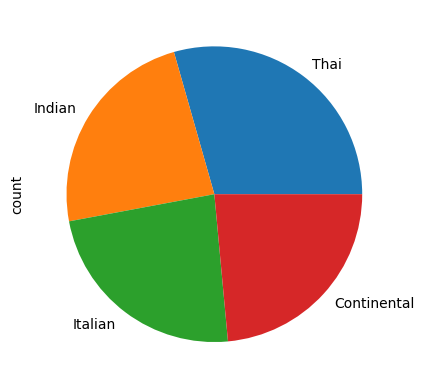

In [136]:
meal['cuisine'].value_counts().plot(kind = 'pie');

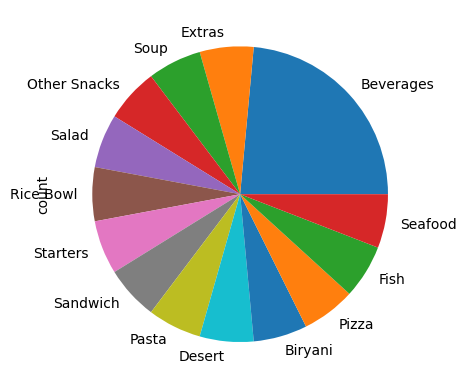

In [137]:
meal['category'].value_counts().plot(kind = 'pie');

##  <font color= darkred> Fulfillment Center Data Inspection</font>🔍🏢

In [138]:
center.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [139]:
center.tail()

,center_id,city_code,region_code,center_type,op_area
72,53,590,56,TYPE_A,3.8
73,30,604,56,TYPE_A,3.5
74,76,614,85,TYPE_A,3.0
75,68,676,34,TYPE_B,4.1
76,51,638,56,TYPE_A,7.0


In [140]:
center.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   center_id    77 non-null     int64  
 1   city_code    77 non-null     int64  
 2   region_code  77 non-null     int64  
 3   center_type  77 non-null     object 
 4   op_area      77 non-null     float64
dtypes: float64(1), int64(3), object(1)
memory usage: 3.1+ KB


In [141]:
center.describe(include='all')

,center_id,city_code,region_code,center_type,op_area
count,77.000000,77.000000,77.000000,77,77.000000
unique,NaN,NaN,NaN,3,NaN
top,NaN,NaN,NaN,TYPE_A,NaN
freq,NaN,NaN,NaN,43,NaN
mean,83.142857,600.662338,56.493506,NaN,3.985714
std,46.090219,66.720274,18.126473,NaN,1.106406
min,10.000000,456.000000,23.000000,NaN,0.900000
25%,50.000000,553.000000,34.000000,NaN,3.500000
50%,77.000000,596.000000,56.000000,NaN,3.900000
75%,110.000000,651.000000,77.000000,NaN,4.400000


* The largest operational area for a center is 7km and smallest is 0.9km 
* Center TYPE_A is the most prelevant with 43 occurances 
* region_code can be interpreted as zip code 

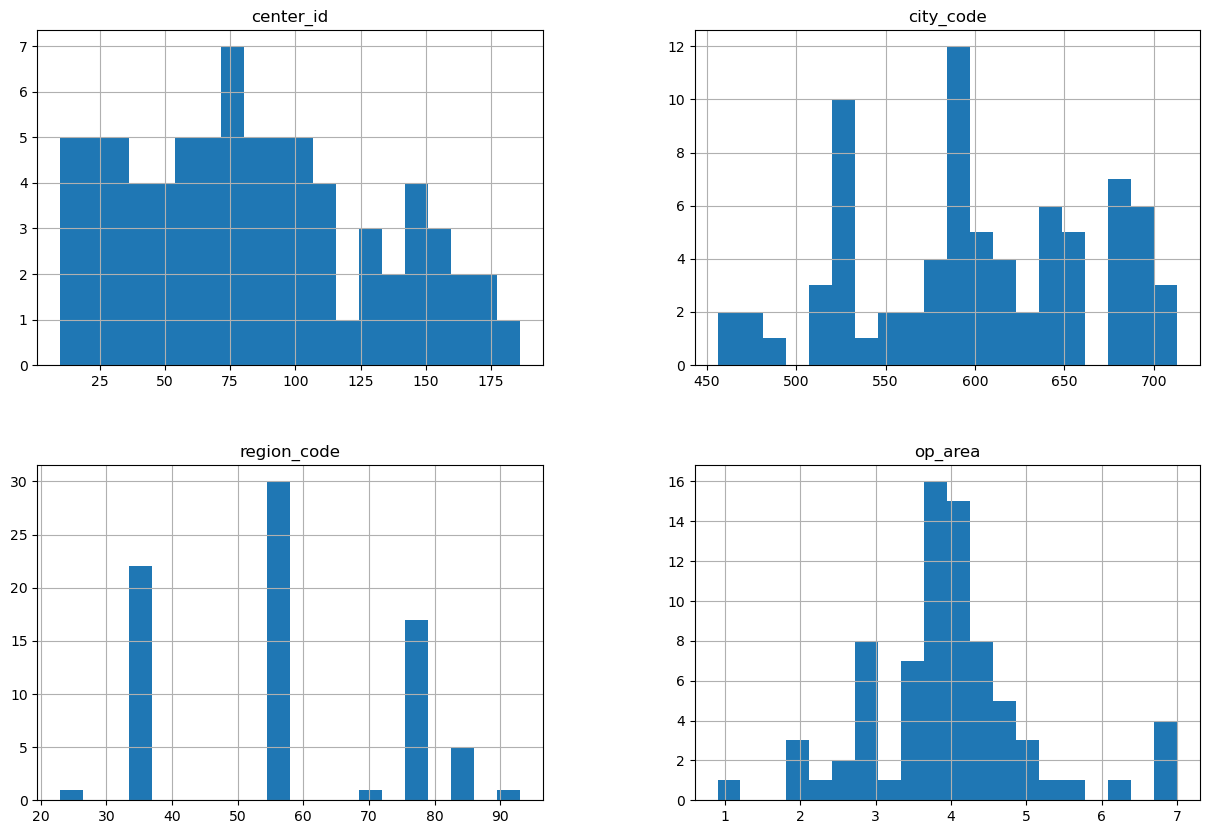

In [142]:
center.hist(figsize = (15, 10), bins = 20);

* Operational Area is the only value that has numerical significance, the others can be categorical values. 

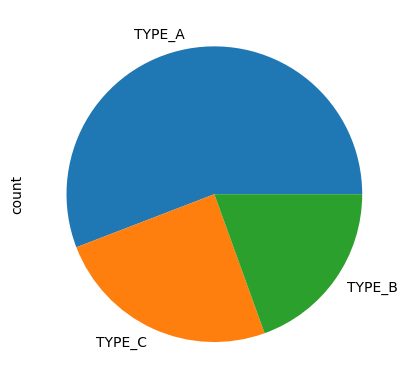

In [143]:
center['center_type'].value_counts().plot(kind = 'pie');

In [144]:
# convert center_id, region_code and city_code to object type
center['center_id'] = center['center_id'].astype('object')
center['region_code'] = center['region_code'].astype('object')
center['city_code'] = center['city_code'].astype('object')

In [145]:
center.dtypes

center_id       object
city_code       object
region_code     object
center_type     object
op_area        float64
dtype: object

##  <font color= darkred> Merge Datasets </font>

In [146]:
# convert center_id and meal_id to object type to prepare for merging 
train['center_id'] = train['center_id'].astype('object')
train['meal_id'] = train['meal_id'].astype('object')

In [147]:
df = train.merge(meal, on='meal_id', how='left')

In [148]:
df = df.merge(center, on='center_id', how='left')
print('New dataset shape: ', df.shape, '\nOld dataset shape: ', train_shape)
df.to_csv(r'C:\Users\M\Desktop\food-demand-forecasting-main\food-demand-forecasting-main\data\merged_original_df.csv', index = False)
df.head()

New dataset shape:  (456548, 15) 
Old dataset shape:  (456548, 9)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai,647,56,TYPE_C,2.0
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian,647,56,TYPE_C,2.0
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian,647,56,TYPE_C,2.0


In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  object 
 3   meal_id                456548 non-null  object 
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
 9   category               456548 non-null  object 
 10  cuisine                456548 non-null  object 
 11  city_code              456548 non-null  object 
 12  region_code            456548 non-null  object 
 13  center_type            456548 non-null  object 
 14  op_area                456548 non-nu

### Rename columns

In [150]:
df.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'category',
       'cuisine', 'city_code', 'region_code', 'center_type', 'op_area'],
      dtype='object')

In [151]:
new_names = ['id', 'week', 'center', 'meal', 'checkout_price', 'base_price',
       'email_promo', 'homepage_featured', 'num_orders', 'meal_category',
       'cuisine', 'city', 'region', 'center_type', 'op_area']

In [152]:
df.columns = new_names # replace the existing names with new names
df.columns

Index(['id', 'week', 'center', 'meal', 'checkout_price', 'base_price',
       'email_promo', 'homepage_featured', 'num_orders', 'meal_category',
       'cuisine', 'city', 'region', 'center_type', 'op_area'],
      dtype='object')

### Create new columns

In [153]:
# create additional columns representing time and seasonality from week 

# Calculate the number of months since January 2020
df['months_since_start'] = (df['week'] - 1) // 4
# Calculate the year based on months since start
df['year'] = 2020 + df['months_since_start'] // 12
# Calculate the month based on months since start
df['month'] = df['months_since_start'] % 12 + 1
# Calculate the quarter based on the month
df['quarter'] = (df['month'] - 1) // 3 + 1
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2) + '-01')

print(df[['week', 'months_since_start', 'year', 'month', 'quarter', 'date']].sample(5))


        week  months_since_start  year  month  quarter       date
227391    75                  18  2021      7        3 2021-07-01
446797   143                  35  2022     12        4 2022-12-01
306833   100                  24  2022      1        1 2022-01-01
288721    94                  23  2021     12        4 2021-12-01
329760   107                  26  2022      3        1 2022-03-01


In [154]:
months_distribution = df.groupby(['year', 'quarter'])['month'].unique().reset_index()
print("Distribution of months across quarters and years:")
months_distribution.head(20)

Distribution of months across quarters and years:


,year,quarter,month
0,2020,1,"[1, 2, 3]"
1,2020,2,"[4, 5, 6]"
2,2020,3,"[7, 8, 9]"
3,2020,4,"[10, 11, 12]"
4,2021,1,"[1, 2, 3]"
5,2021,2,"[4, 5, 6]"
6,2021,3,"[7, 8, 9]"
7,2021,4,"[10, 11, 12]"
8,2022,1,"[1, 2, 3]"
9,2022,2,"[4, 5, 6]"


In [155]:
# Summary statistics for each year and quarter
summary_stats = df.groupby(['year', 'quarter'])['month'].agg(['count', 'min', 'max']).reset_index()
print("Summary statistics for each year and quarter:")
summary_stats.head(20)

Summary statistics for each year and quarter:


,year,quarter,count,min,max
0,2020,1,34299,1,3
1,2020,2,34891,4,6
2,2020,3,36393,7,9
3,2020,4,36868,10,12
4,2021,1,37728,1,3
5,2021,2,38230,4,6
6,2021,3,38677,7,9
7,2021,4,39145,10,12
8,2022,1,38984,1,3
9,2022,2,39183,4,6


In [156]:
df.tail() # dataset includes up until 2023-01-01

,id,week,center,meal,checkout_price,base_price,email_promo,homepage_featured,num_orders,meal_category,cuisine,city,region,center_type,op_area,months_since_start,year,month,quarter,date
456543,1271326,145,61,1543,484.09,484.09,0,0,68,Desert,Indian,473,77,TYPE_A,4.5,36,2023,1,1,2023-01-01
456544,1062036,145,61,2304,482.09,482.09,0,0,42,Desert,Indian,473,77,TYPE_A,4.5,36,2023,1,1,2023-01-01
456545,1110849,145,61,2664,237.68,321.07,0,0,501,Salad,Italian,473,77,TYPE_A,4.5,36,2023,1,1,2023-01-01
456546,1147725,145,61,2569,243.50,313.34,0,0,729,Salad,Italian,473,77,TYPE_A,4.5,36,2023,1,1,2023-01-01
456547,1361984,145,61,2490,292.03,290.03,0,0,162,Salad,Italian,473,77,TYPE_A,4.5,36,2023,1,1,2023-01-01


In [157]:
# add discount and discount percent columns 
df['discount'] = df['base_price'] - df['checkout_price']
df['discount'] = df['discount'].apply(lambda x: x if x > 0 else 0)

df['discount_percent'] = (df['discount'] / df['base_price']) * 100
df['discount_percent'] = df['discount_percent'].replace([float('inf'), -float('inf')], 0).fillna(0)
df[['base_price', 'checkout_price', 'discount', 'discount_percent']].sample(5)

,base_price,checkout_price,discount,discount_percent
258961,292.03,292.03,0.0,0.000000
234844,562.63,563.63,0.0,0.000000
350614,328.86,327.86,1.0,0.304081
252244,484.03,484.03,0.0,0.000000
151536,327.89,327.89,0.0,0.000000


### Drop Columns 

In [158]:
df.columns

Index(['id', 'week', 'center', 'meal', 'checkout_price', 'base_price',
       'email_promo', 'homepage_featured', 'num_orders', 'meal_category',
       'cuisine', 'city', 'region', 'center_type', 'op_area',
       'months_since_start', 'year', 'month', 'quarter', 'date', 'discount',
       'discount_percent'],
      dtype='object')

### Reorder columns

In [160]:
# move the target column to the last position 
df = df[['id', 'week', 'checkout_price', 'base_price','discount','discount_percent', 
       'email_promo', 'homepage_featured', 'meal', 'meal_category', 'cuisine', 'city',
       'region', 'center', 'center_type', 'op_area', 'year',
       'quarter', 'month', 'date', 'num_orders']]
df.head()

,id,week,checkout_price,base_price,discount,discount_percent,email_promo,homepage_featured,meal,meal_category,cuisine,city,region,center,center_type,op_area,year,quarter,month,date,num_orders
0,1379560,1,136.83,152.29,15.46,10.151684,0,0,1885,Beverages,Thai,647,56,55,TYPE_C,2.0,2020,1,1,2020-01-01,177
1,1466964,1,136.83,135.83,0.00,0.000000,0,0,1993,Beverages,Thai,647,56,55,TYPE_C,2.0,2020,1,1,2020-01-01,270
2,1346989,1,134.86,135.86,1.00,0.736052,0,0,2539,Beverages,Thai,647,56,55,TYPE_C,2.0,2020,1,1,2020-01-01,189
3,1338232,1,339.50,437.53,98.03,22.405321,0,0,2139,Beverages,Indian,647,56,55,TYPE_C,2.0,2020,1,1,2020-01-01,54
4,1448490,1,243.50,242.50,0.00,0.000000,0,0,2631,Beverages,Indian,647,56,55,TYPE_C,2.0,2020,1,1,2020-01-01,40


### Change datatypes

In [161]:
df.dtypes

id                            int64
week                          int64
checkout_price              float64
base_price                  float64
discount                    float64
discount_percent            float64
email_promo                   int64
homepage_featured             int64
meal                         object
meal_category                object
cuisine                      object
city                         object
region                       object
center                       object
center_type                  object
op_area                     float64
year                          int64
quarter                       int64
month                         int64
date                 datetime64[ns]
num_orders                    int64
dtype: object

### Save new Dataframe to csv 

In [162]:
# save df to csv 
df.to_csv(r'C:\Users\M\Desktop\food-demand-forecasting-main\food-demand-forecasting-main\data\df_modified.csv', index = False)
df_orig = df.copy()

##   <font color= darkred> EDA </font>

### <font color= darkred> Numerical inspection and summaries </font>

In [163]:
df.describe(include= 'all').round(2)

,id,week,checkout_price,base_price,discount,discount_percent,email_promo,homepage_featured,meal,meal_category,cuisine,city,region,center,center_type,op_area,year,quarter,month,date,num_orders
count,456548.00,456548.00,456548.00,456548.00,456548.00,456548.00,456548.00,456548.00,456548.0,456548,456548,456548.0,456548.0,456548.0,456548,456548.00,456548.00,456548.00,456548.00,456548,456548.00
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.0,14,4,51.0,8.0,77.0,3,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2290.0,Beverages,Italian,590.0,56.0,13.0,TYPE_A,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11138.0,127890,122925,54746.0,191228.0,7046.0,262881,NaN,NaN,NaN,NaN,NaN,NaN
mean,1250096.31,74.77,332.24,354.16,22.39,5.90,0.08,0.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.08,2021.05,2.51,6.51,2021-07-03 18:58:26.354644224,261.87
min,1000000.00,1.00,45.62,55.35,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.90,2020.00,1.00,1.00,2020-01-01 00:00:00,13.00
25%,1124998.75,39.00,228.95,243.50,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.60,2020.00,1.00,3.00,2020-10-01 00:00:00,54.00
50%,1250183.50,76.00,296.82,310.46,1.00,0.14,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,2021.00,3.00,7.00,2021-07-01 00:00:00,136.00
75%,1375140.25,111.00,445.23,458.87,16.52,6.24,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.50,2022.00,4.00,10.00,2022-04-01 00:00:00,324.00
max,1499999.00,145.00,866.27,866.27,561.60,82.37,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.00,2023.00,4.00,12.00,2023-01-01 00:00:00,24299.00


In [164]:
df.describe()

,id,week,checkout_price,base_price,discount,discount_percent,email_promo,homepage_featured,op_area,year,quarter,month,date,num_orders
count,4.565480e+05,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000,456548.000000,456548.000000,456548.000000,456548,456548.000000
mean,1.250096e+06,74.768771,332.239577,354.156627,22.388699,5.895378,0.081152,0.10920,4.083590,2021.046291,2.506337,6.514463,2021-07-03 18:58:26.354644224,261.872760
min,1.000000e+06,1.000000,45.620000,55.350000,0.000000,0.000000,0.000000,0.00000,0.900000,2020.000000,1.000000,1.000000,2020-01-01 00:00:00,13.000000
25%,1.124999e+06,39.000000,228.950000,243.500000,0.000000,0.000000,0.000000,0.00000,3.600000,2020.000000,1.000000,3.000000,2020-10-01 00:00:00,54.000000
50%,1.250184e+06,76.000000,296.820000,310.460000,1.000000,0.141217,0.000000,0.00000,4.000000,2021.000000,3.000000,7.000000,2021-07-01 00:00:00,136.000000
75%,1.375140e+06,111.000000,445.230000,458.870000,16.520000,6.239530,0.000000,0.00000,4.500000,2022.000000,4.000000,10.000000,2022-04-01 00:00:00,324.000000
max,1.499999e+06,145.000000,866.270000,866.270000,561.600000,82.370821,1.000000,1.00000,7.000000,2023.000000,4.000000,12.000000,2023-01-01 00:00:00,24299.000000
std,1.443548e+05,41.524956,152.938956,160.715914,48.214009,11.231763,0.273069,0.31189,1.091686,0.826136,1.120925,3.469822,NaN,395.922798


### Numerical Features 

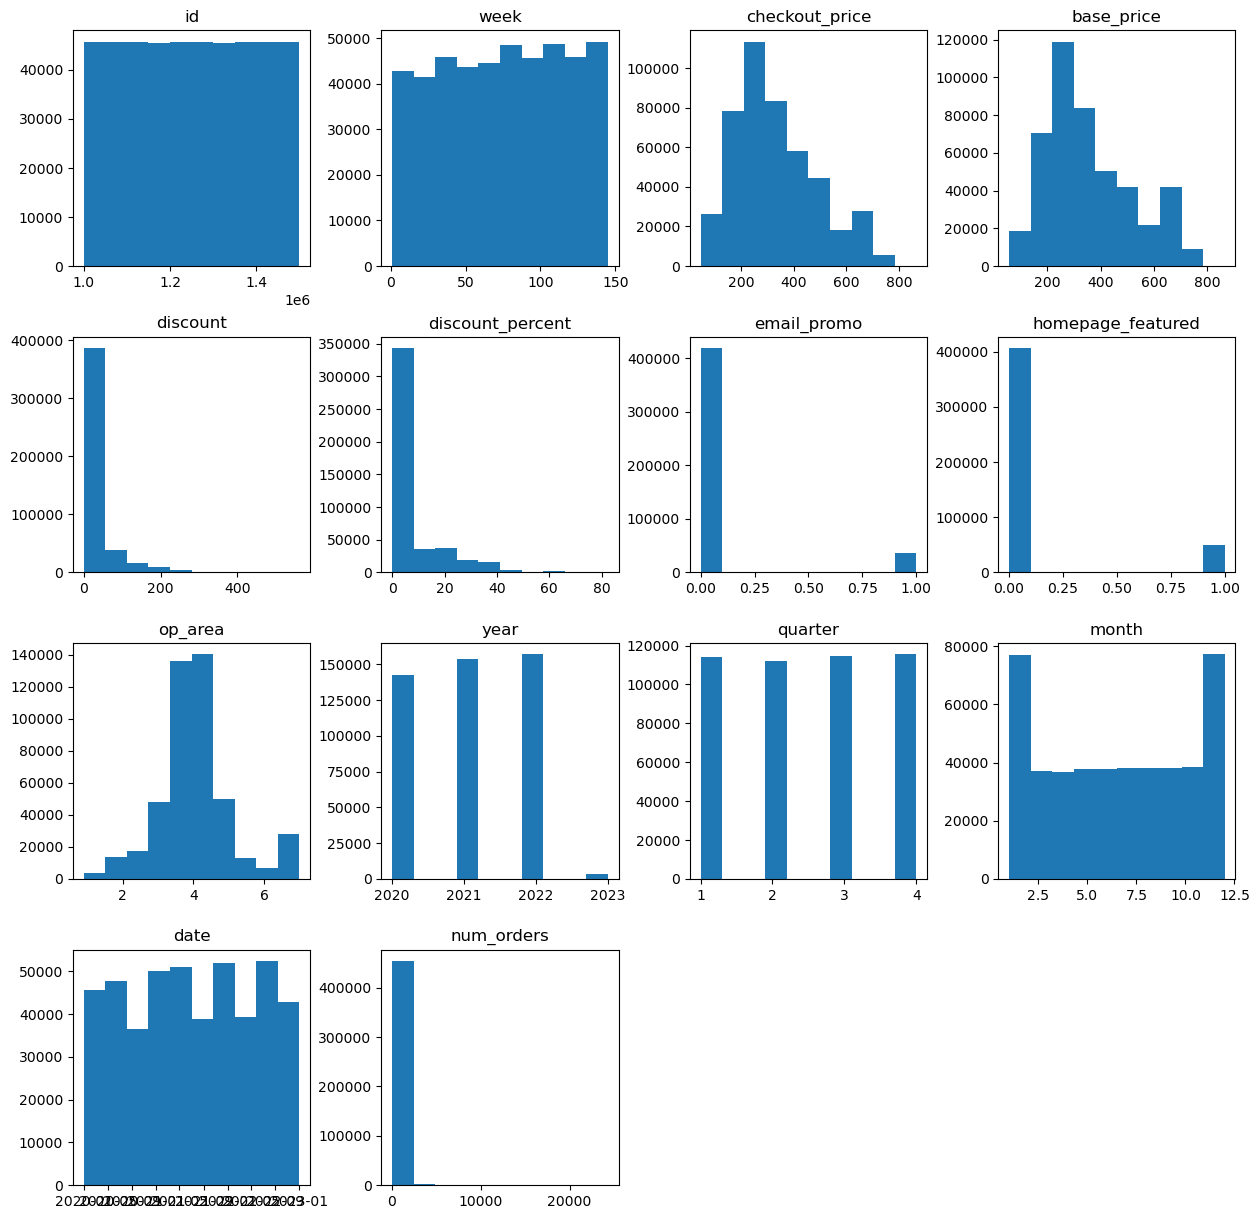

In [165]:
df.hist(figsize = (15, 15), grid = False);

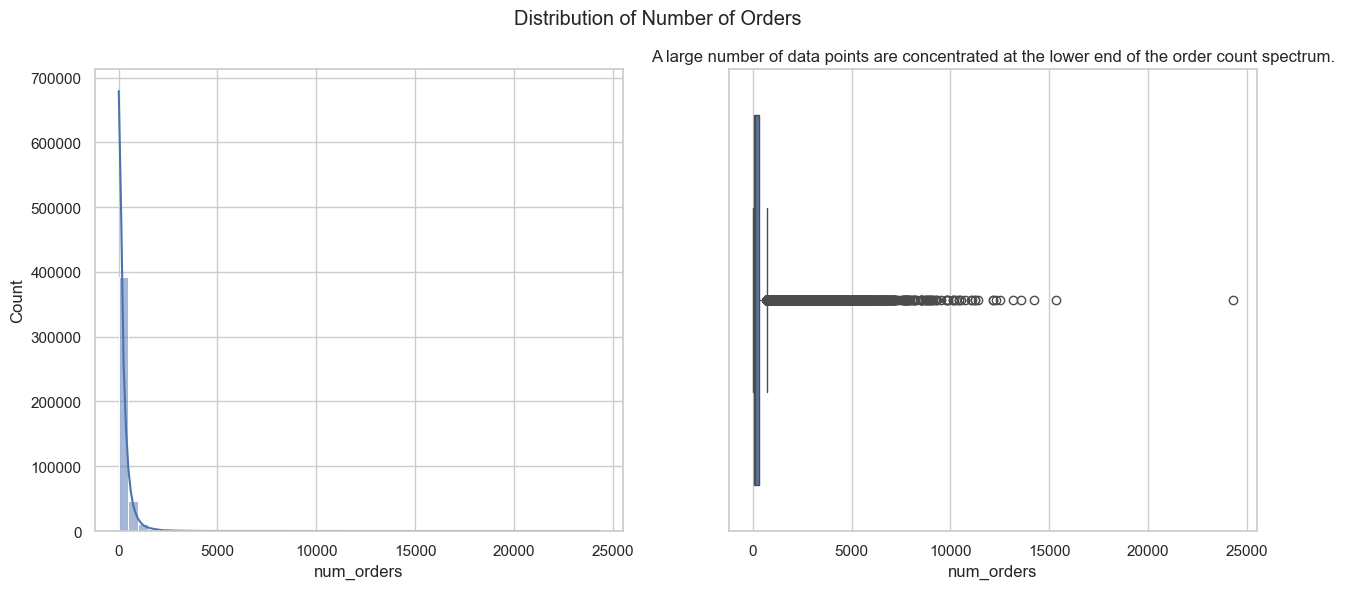

In [557]:
# plot histogram and box plot next to each other 
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(df_orig['num_orders'], bins=50, kde=True, ax=axes[0])
sns.boxplot(x = df_orig['num_orders'], ax=axes[1])
plt.suptitle('Distribution of Number of Orders')
plt.title('A large number of data points are concentrated at the lower end of the order count spectrum.')
plt.show()

In [310]:
# how many unique meals does each distribution center offer on average per week?
unique_meals = df.groupby('center').agg({'meal': 'nunique'}).reset_index()
unique_meals
unique_meals['meal'].mean()

46.714285714285715

In [590]:
# average number of of orders per center per week
center_week_orders = df_orig.groupby(['center', 'week'])['num_orders'].sum().reset_index()
center_avg_orders = center_week_orders.groupby('center')['num_orders'].mean().reset_index()
high = center_avg_orders['num_orders'].max()
low = center_avg_orders['num_orders'].min()
mean = center_avg_orders['num_orders'].mean()
print(f'High: {high}')
print(f'Low: {low}')
print(f'Mean: {mean}')

High: 29631.344827586207
Low: 2932.137931034483
Mean: 10745.511699507388


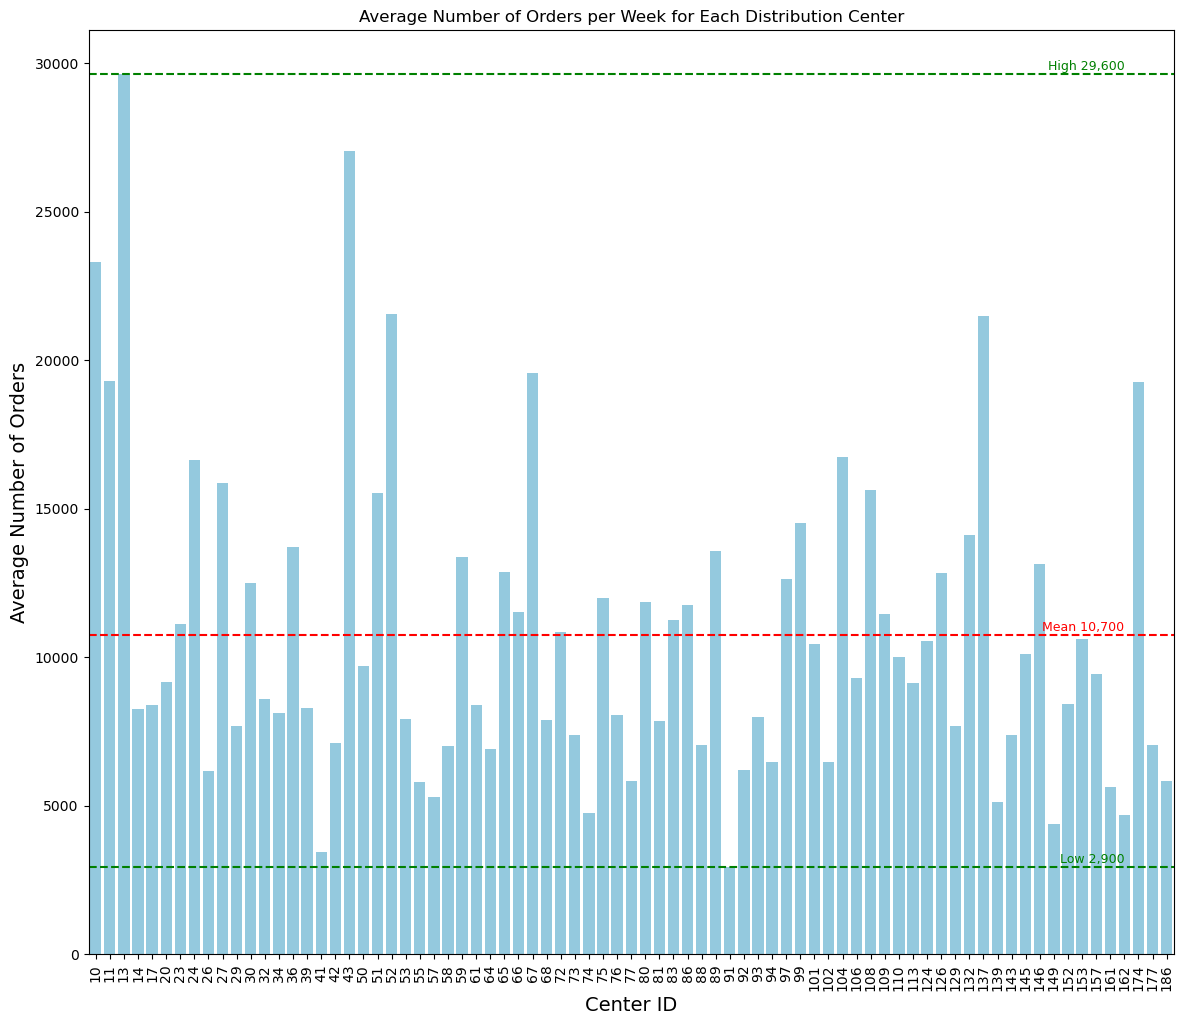

In [404]:
plt.figure(figsize=(14, 12))
sns.barplot(data=center_avg_orders, x='center', y='num_orders', color = 'skyblue')
plt.axhline(mean, color='red', linestyle='--', label='Mean')
plt.text(73, mean + 260, f'Mean 10,700', fontsize=9, va='center', ha='right', color='red')
plt.axhline(high, color='green', linestyle='--', label='High')
plt.text(73, high + 260, f'High 29,600', fontsize=9, va='center', ha='right', color='green')
plt.axhline(low, color='green', linestyle='--', label='Low')
plt.text(73, low + 260, f'Low 2,900', fontsize=9, va='center', ha='right', color='green')
plt.xlabel('Center ID', fontsize=14)
plt.ylabel('Average Number of Orders', fontsize=14)
plt.title('Average Number of Orders per Week for Each Distribution Center')
plt.xticks(rotation=90)
plt.show()

### Categorical Features 

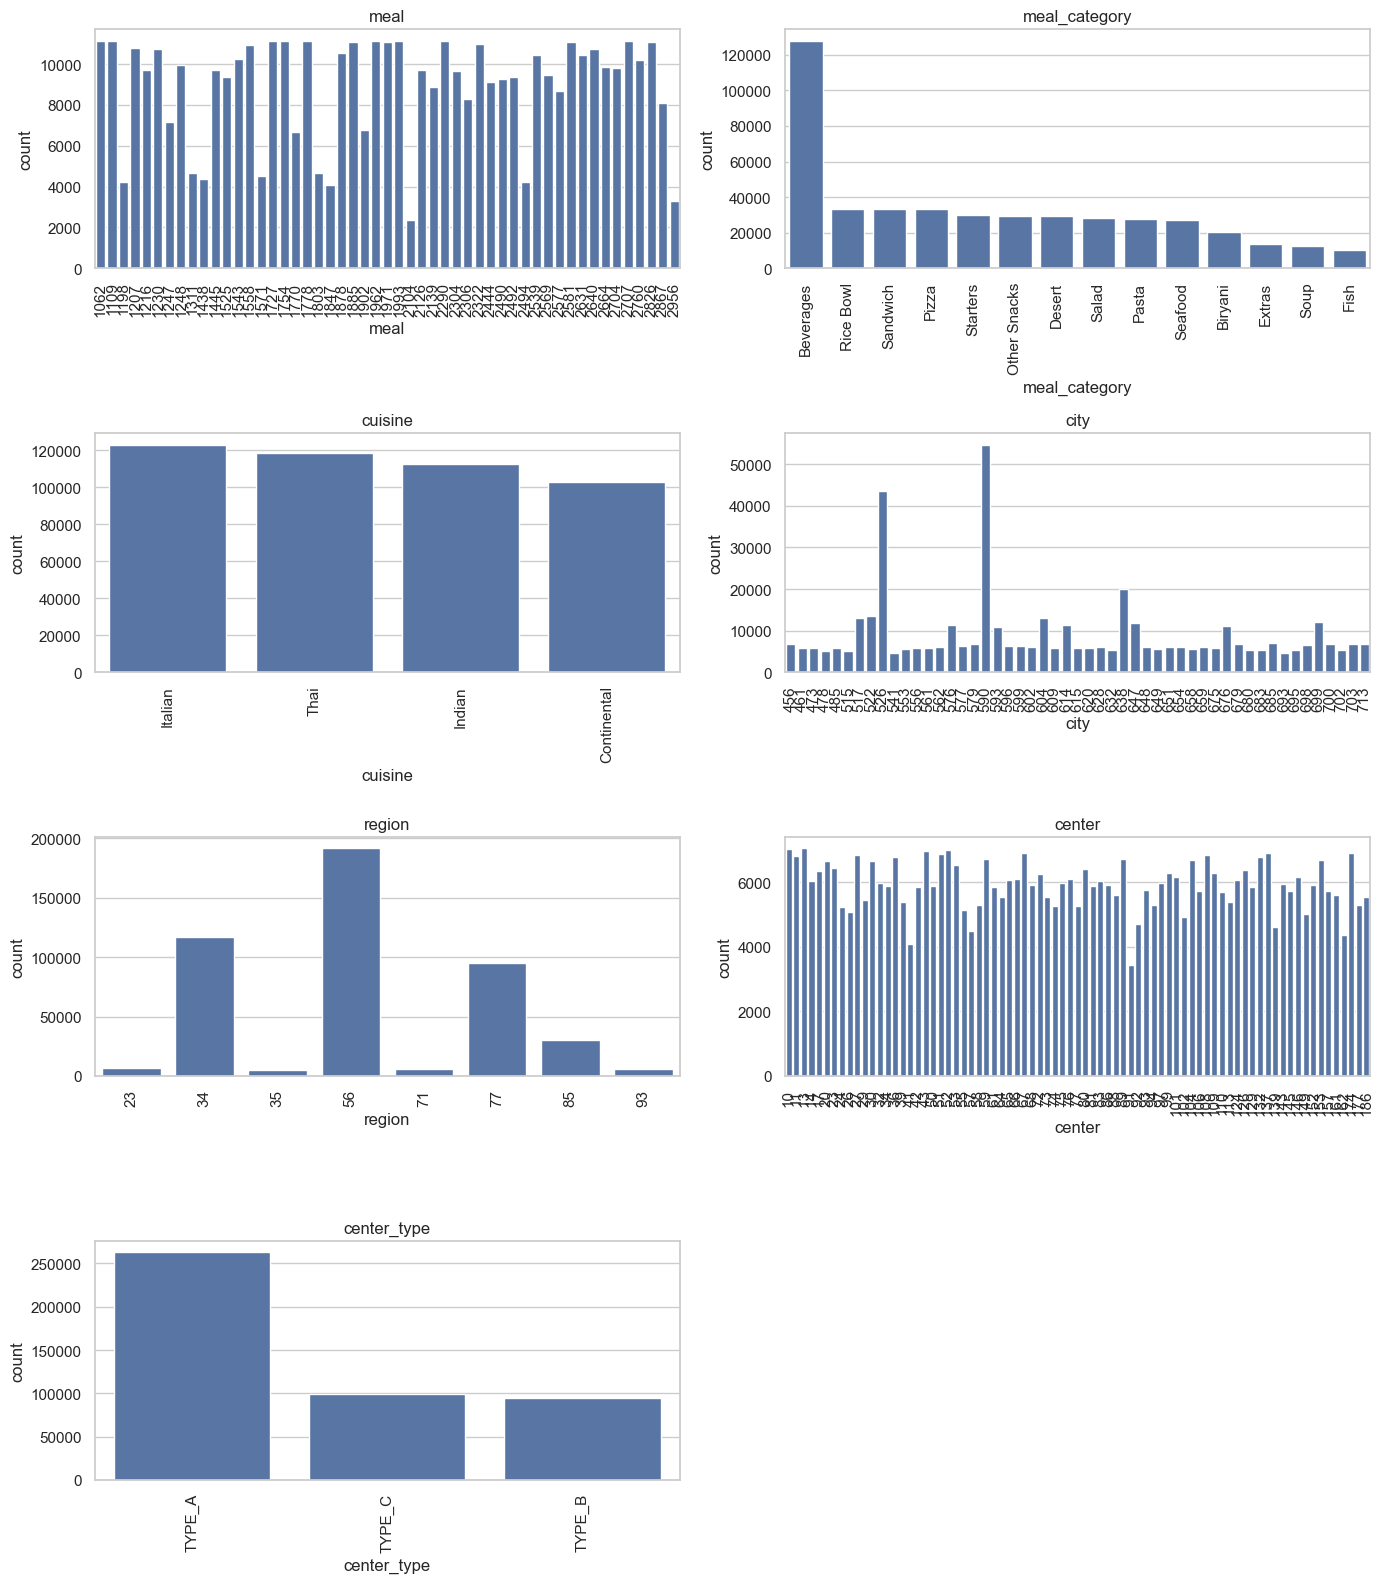

In [568]:
n_categories = 7
n_cols = 2
n_rows = n_categories // n_cols + (n_categories % n_cols > 0)
cat = df_orig[['meal', 'meal_category', 'cuisine', 'city', 'region', 'center', 'center_type']]              
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*7, n_rows*4))
axs = axs.flatten()
for i, column in enumerate(cat.columns):
    # Plot each category in its subplot
    sns.barplot(x=cat[column].value_counts().index, 
                y=cat[column].value_counts(), 
                ax=axs[i])
    axs[i].set_title(column)
    # Get current x-tick labels and set them with a 90-degree rotation
    labels = axs[i].get_xticklabels()
    axs[i].set_xticklabels(labels, rotation=90)

for i in range(n_categories, len(axs)):
    axs[i].set_visible(False)
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

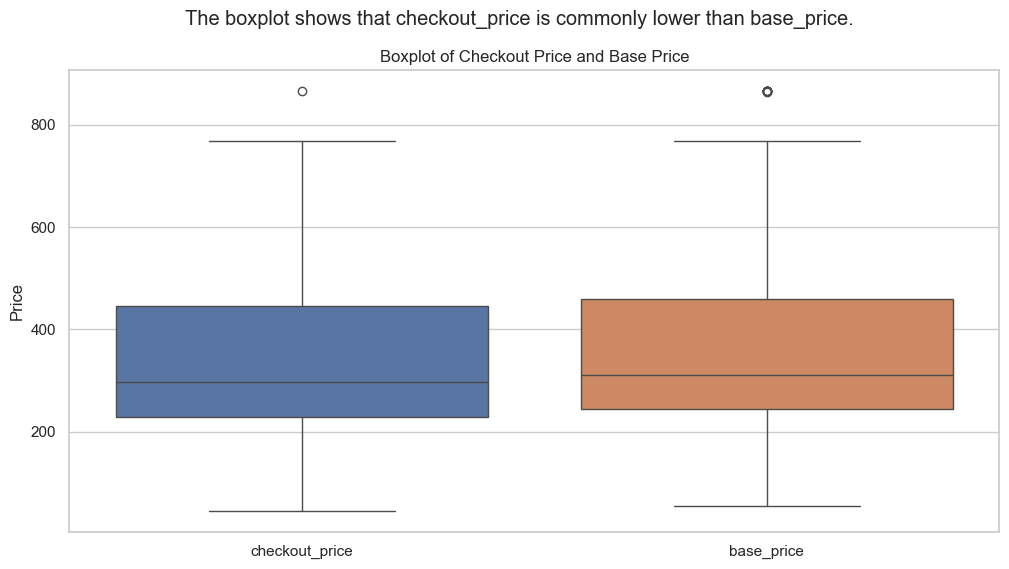

In [572]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_orig[['checkout_price', 'base_price']])
plt.title('Boxplot of Checkout Price and Base Price')
plt.suptitle('The boxplot shows that checkout_price is commonly lower than base_price.')
plt.ylabel('Price')
plt.savefig('images/boxplot_prices.png')
plt.show()

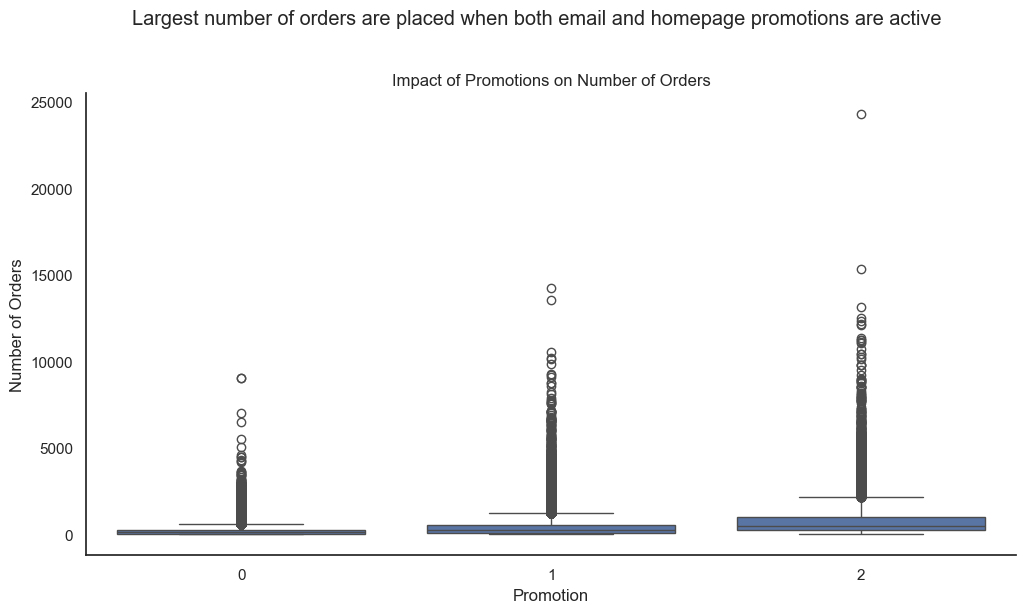

In [579]:
# Imapact of Promotions on Numbers of Orders
# add a column that adds a value 1 when either email_promo or homepage_featured is 1
df_orig['promo'] = df_orig['email_promo'] + df_orig['homepage_featured']
plt.figure(figsize=(12, 6))
with sns.axes_style("white"):
    sns.boxplot(x='promo', y='num_orders', data=df_orig)
plt.title('Impact of Promotions on Number of Orders')
plt.suptitle('Largest number of orders are placed when both email and homepage promotions are active', y=1.02)
plt.xlabel('Promotion')
plt.ylabel('Number of Orders')
sns.despine()
plt.savefig('images/impact_promotion_num_orders.png')
plt.show()

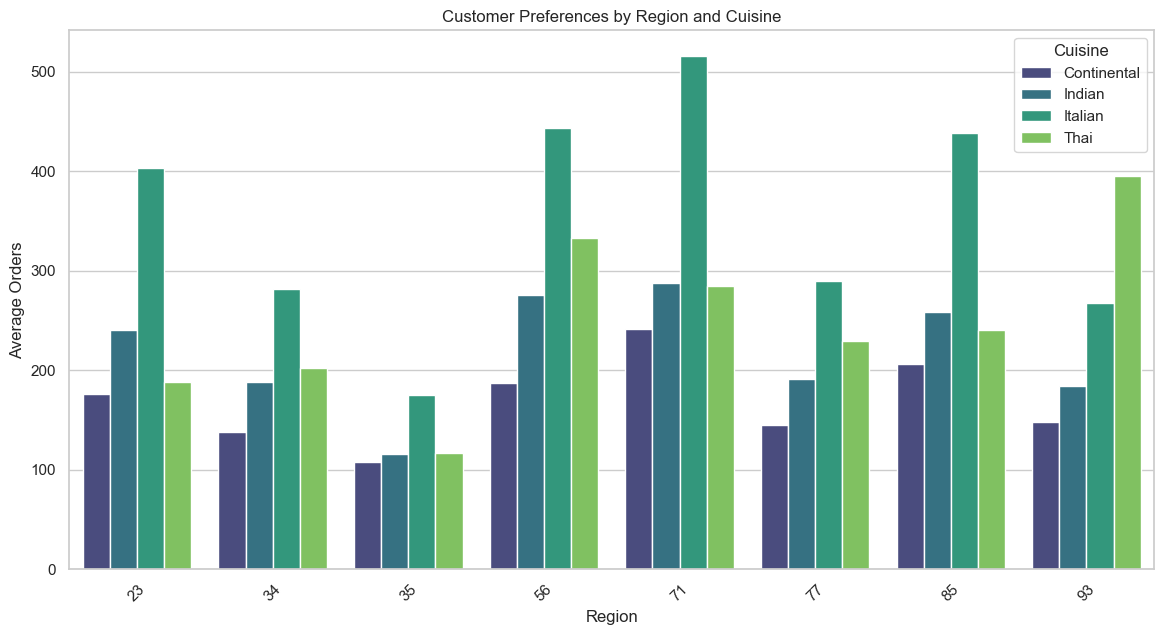

In [584]:
customer_prefs = df.groupby(['region', 'cuisine'])['num_orders'].mean().reset_index()

plt.figure(figsize=(14, 7))
sns.barplot(data=customer_prefs, x='region', y='num_orders', hue='cuisine', palette='viridis')
plt.xlabel('Region')
plt.ylabel('Average Orders')
plt.title('Customer Preferences by Region and Cuisine')
plt.suptitle('Indian is the most popular in most regions')
plt.legend(title='Cuisine')
plt.xticks(rotation=45)
plt.show()

### Seasonality

Text(0.5, 0.98, 'Number of orders decrease slightly from 2020 onwards, 2023 is not a full year')

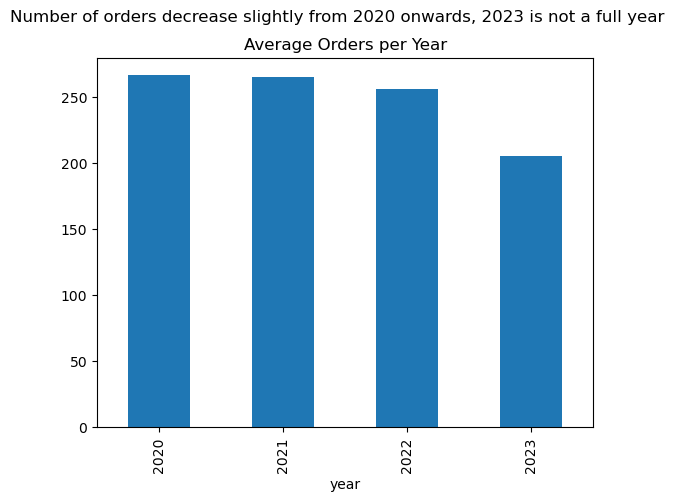

In [166]:
df.groupby('year')['num_orders'].mean().plot(kind = 'bar');
plt.title('Average Orders per Year')
plt.suptitle('Number of orders decrease slightly from 2020 onwards, 2023 is not a full year')

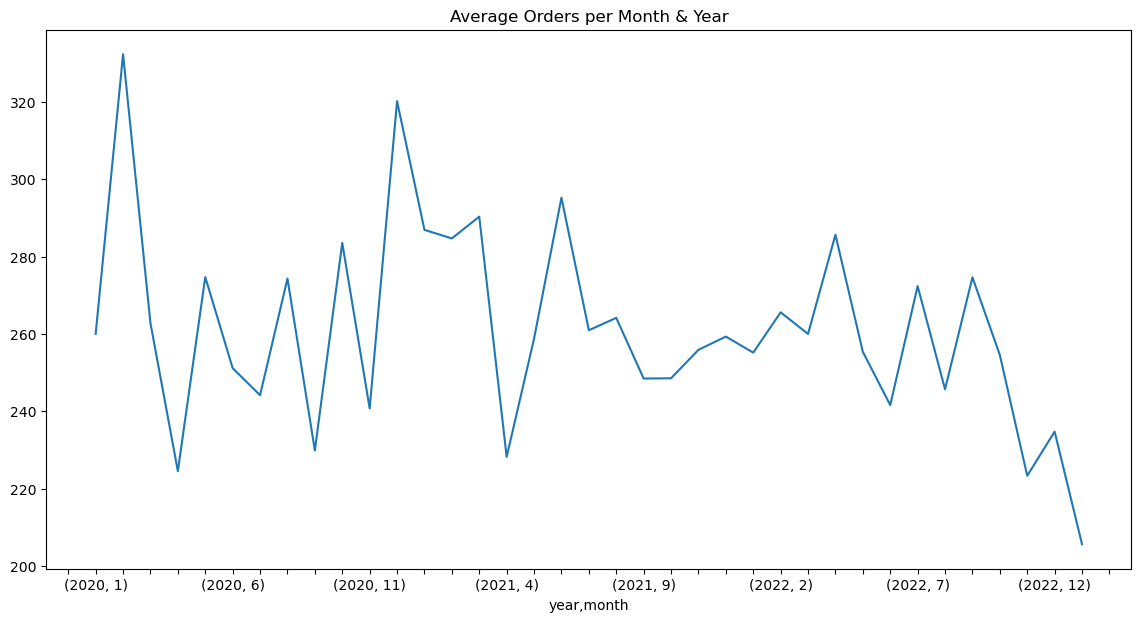

In [168]:
plt.figure(figsize = (18, 10))
df.groupby(['year','month'])['num_orders'].mean().plot(kind = 'line', title = 'Average Orders per Month & Year', figsize = (14, 7));
plt.savefig('Average Orders per Month & Year.png')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

In [169]:
monthly = df.groupby(['year', 'month'], as_index = False)['num_orders'].mean()
monthly.tail()

,year,month,num_orders
32,2022,9,274.661305
33,2022,10,254.578708
34,2022,11,223.330322
35,2022,12,234.743973
36,2023,1,205.607711


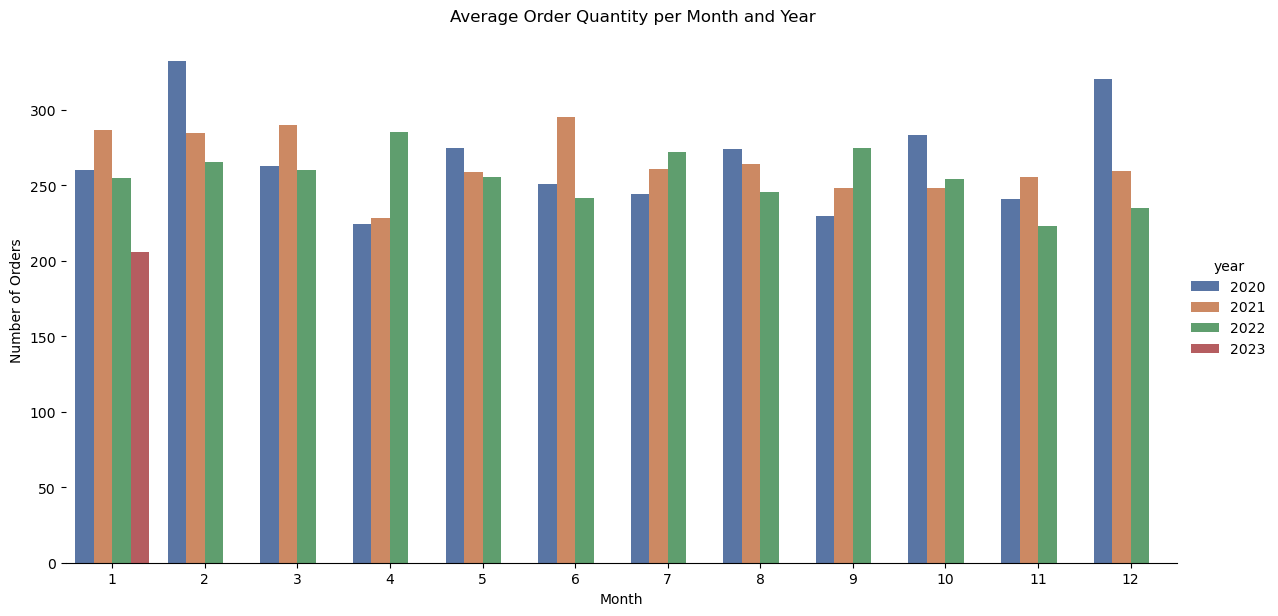

In [170]:
g = sns.catplot(
    data=monthly,
    x='month', y='num_orders', hue='year',
    kind='bar', height=6, aspect=2,
    palette='deep'
)
g.set_axis_labels('Month', 'Number of Orders')
g.set_titles('Number of Orders per Month and Year')
g.despine(left=True)
g.fig.suptitle('Average Order Quantity per Month and Year', y=1.02)  # Adjust suptitle position
plt.show()


In [173]:
quarterly = df.groupby(['year', 'quarter'], as_index = False)['num_orders'].mean()
quarterly.tail()

,year,quarter,num_orders
8,2022,1,260.220347
9,2022,2,260.813465
10,2022,3,264.320013
11,2022,4,237.562456
12,2023,1,205.607711


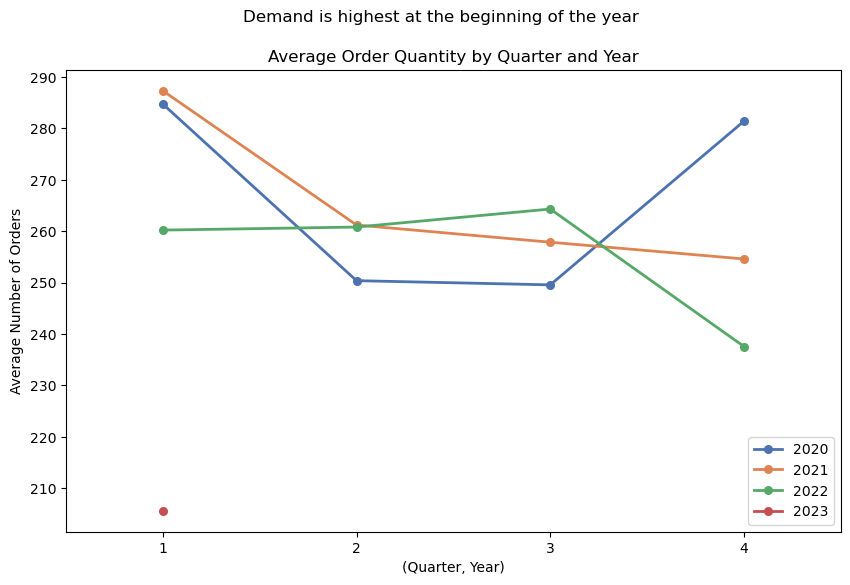

In [174]:
plt.figure(figsize=(10, 6))
ax = sns.pointplot(data=quarterly, x='quarter', y='num_orders', hue='year', palette='deep', linewidth=2)
ax.legend(loc='lower right')
ax.set_xlabel('(Quarter, Year)')
ax.set_ylabel('Average Number of Orders')
ax.set_title('Average Order Quantity by Quarter and Year')
plt.suptitle('Demand is highest at the beginning of the year')
plt.show()

* Spike in the number of orders in Januray
* Quarterly Plot shows us spikes in Q1, Q4 and Q5 and a low in Q2 and Q3

In [175]:
monthly_cuisine = df.groupby(['year', 'month', 'cuisine'], as_index=False)['num_orders'].mean()
monthly_cuisine.head()

,year,month,cuisine,num_orders
0,2020,1,Continental,200.560000
1,2020,1,Indian,205.309925
2,2020,1,Italian,307.962116
3,2020,1,Thai,319.812941
4,2020,2,Continental,139.855750


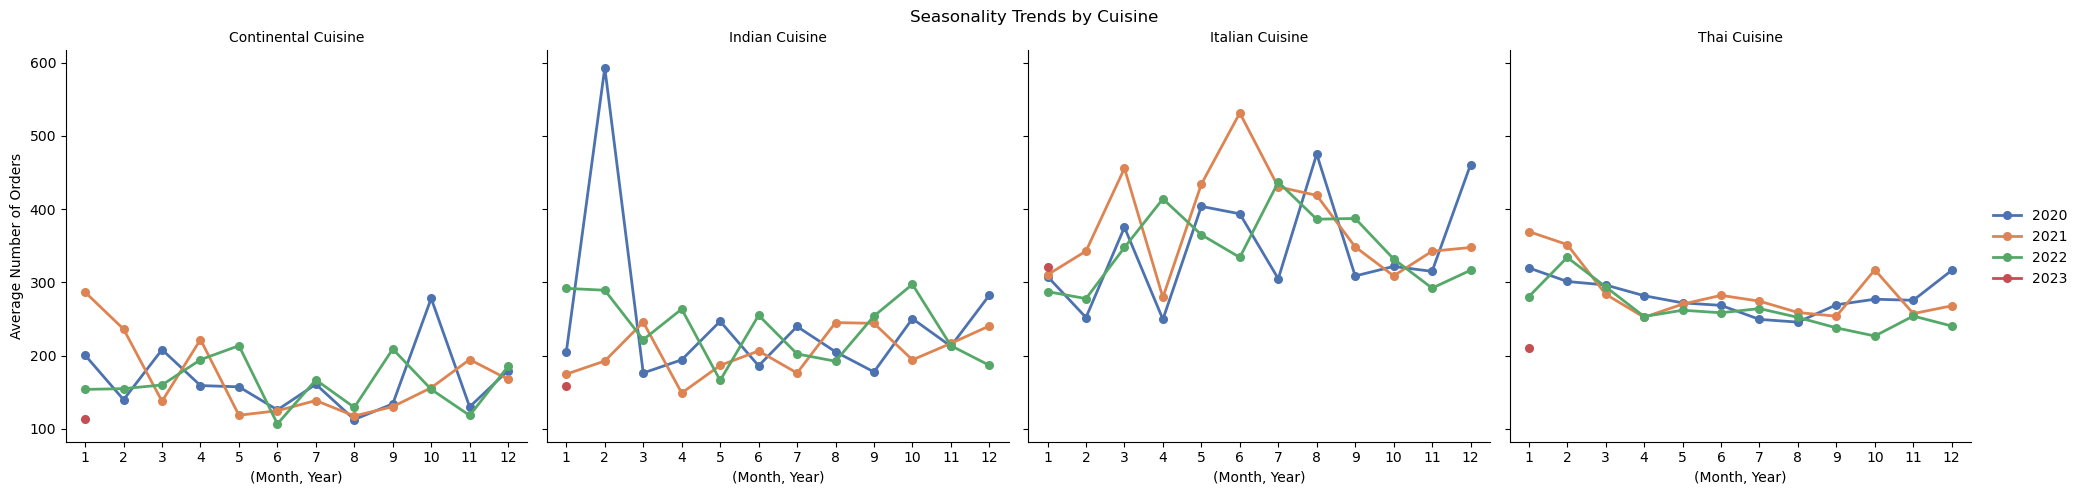

In [176]:
g = sns.FacetGrid(monthly_cuisine, col="cuisine", col_wrap=4, height=5, sharey=True)
g.map(sns.pointplot, 'month', 'num_orders', 'year', palette='deep', linewidth=2)
g.add_legend()
g.set_axis_labels('(Month, Year)', 'Average Number of Orders')
g.set_titles(col_template='{col_name} Cuisine')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Seasonality Trends by Cuisine')
plt.savefig('seasonality_cuisine.png')
plt.show()

In [177]:
monthly_category = df.groupby(['year', 'month', 'meal_category'], as_index=False)['num_orders'].mean()
monthly_category.head()

,year,month,meal_category,num_orders
0,2020,1,Beverages,390.463408
1,2020,1,Biryani,42.742378
2,2020,1,Desert,60.976773
3,2020,1,Extras,341.811170
4,2020,1,Other Snacks,181.137626


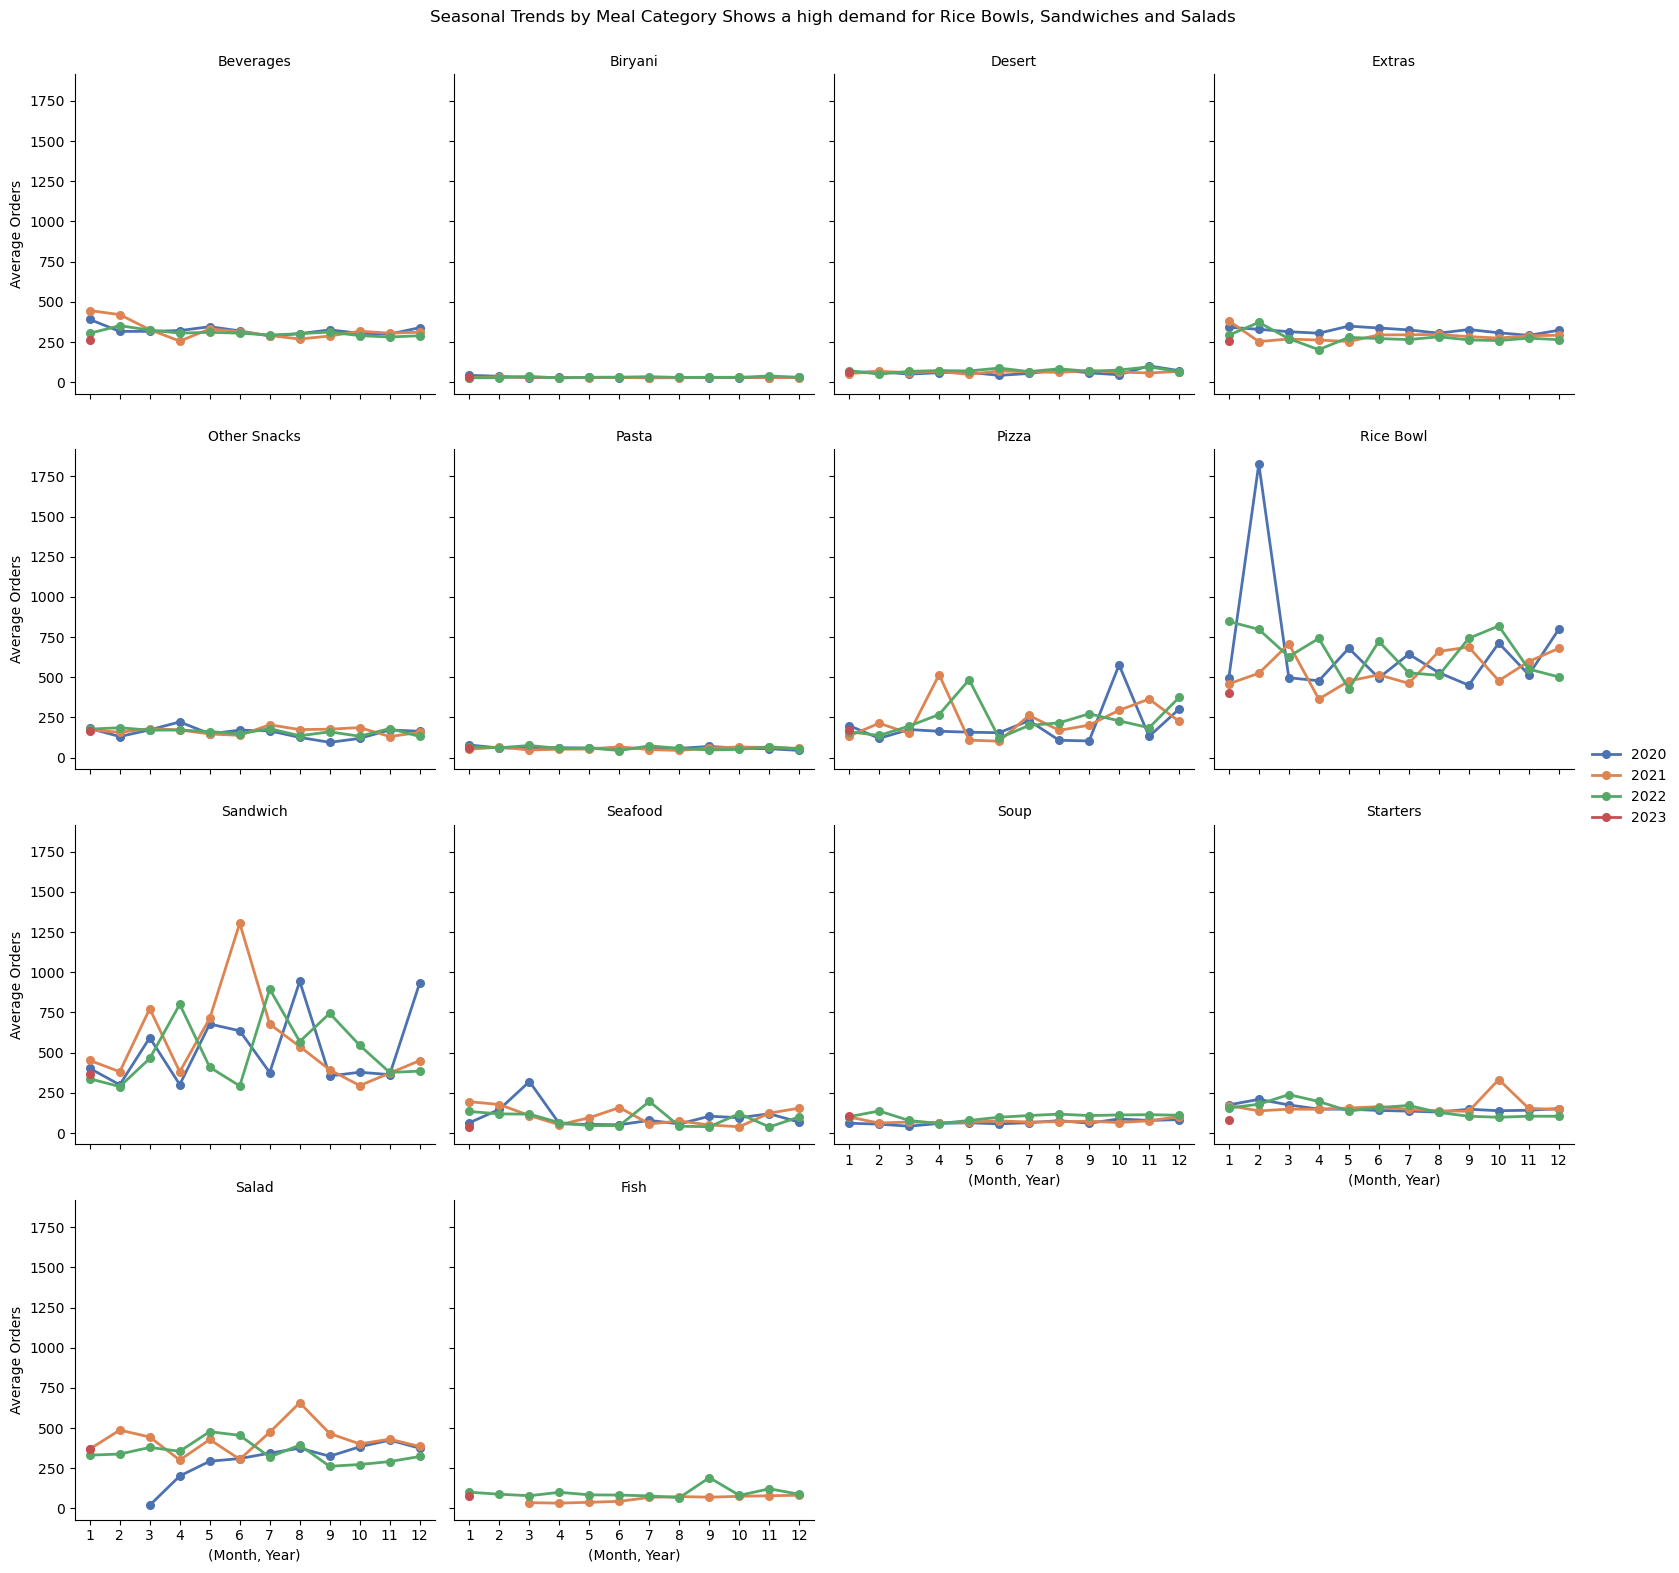

In [178]:
palette = sns.color_palette("deep", n_colors=4)
year_palette = {2020: palette[0], 2021: palette[1], 2022: palette[2], 2023: palette[3]}

g = sns.FacetGrid(monthly_category, col="meal_category", col_wrap=4, height=4, sharey=True)
g.map(sns.pointplot, 'month', 'num_orders', 'year', palette=year_palette, linewidth=2)
g.add_legend()
g.set_axis_labels('(Month, Year)', 'Average Orders')
g.set_titles(col_template='{col_name}')
plt.subplots_adjust(top=0.94)
g.fig.suptitle('Seasonal Trends by Meal Category Shows a high demand for Rice Bowls, Sandwiches and Salads')

plt.show()

### Correlation

#### Bivariate Analysis

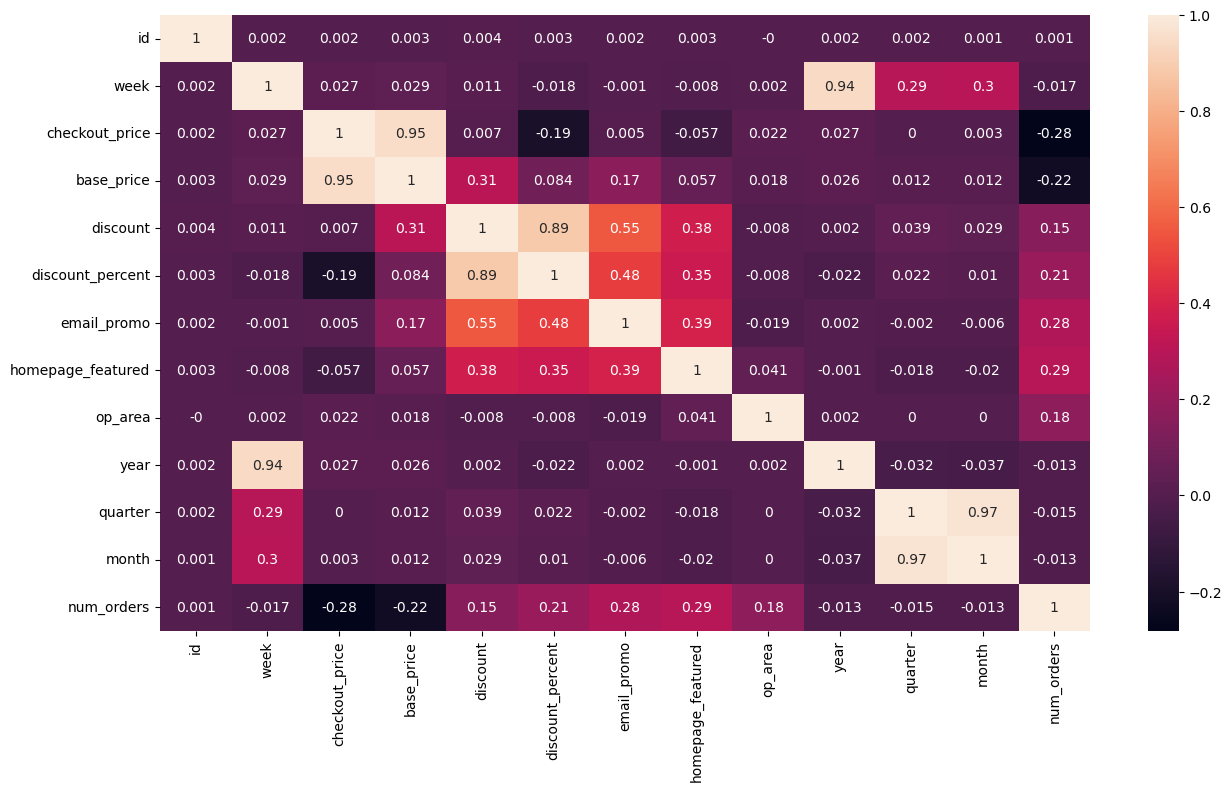

In [179]:
corr = df.corr(numeric_only = True).round(3)
plt.figure(figsize= (15,8))
sns.heatmap(corr, annot= True);

* `order_num` have a slight positive correlation with homepage featured and email promo, meaning that marketing increases number of orders
* `order_num` also has a positive correlation with discount percent which shows as discount percent goes up, number of orders goes up aswell. 
* `order_num` has a negative correlation with checkout price and base price, as the price increases the number of orders decreases

### Check for Multicollinearity 

In [180]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Calculate VIF for each feature
# We need to drop non-numeric columns and the target variable for VIF calculation
df_numeric = df.select_dtypes(include=[np.number]).drop(columns=['num_orders'])
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')

# Add a constant column for the intercept term
df_numeric = sm.add_constant(df_numeric)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = df_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(df_numeric.values, i) for i in range(df_numeric.shape[1])]
# sort values by VIF
vif_data = vif_data.sort_values(by="VIF", ascending=False)
vif_data

,feature,VIF
4,base_price,4530.890315
3,checkout_price,4101.923002
2,week,1371.838609
10,year,1250.364159
5,discount,415.954707
12,month,172.369458
11,quarter,18.058180
6,discount_percent,5.694346
7,email_promo,1.531304
8,homepage_featured,1.287573


We will proceed with removing highly correlated features 
* `base_price`
* `discount`
* `year`

In [181]:
df.drop(columns = ['base_price', 'discount', 'year', 'date'], inplace = True)

In [183]:
# save csv 
df.to_csv(r'C:\Users\M\Desktop\food-demand-forecasting-main\food-demand-forecasting-main\data\food_demand_forecasting_final.csv', index = False)

##  <font color= darkred> Feature Engineering </font>

In [187]:
target_feature = 'num_orders'  
categorical_features = ['center', 'meal', 'meal_category', 'cuisine', 'city', 'region', 'center_type']        
t_var = 'week'  # unit of 'time'
id_var = 'id'  # common column to identify submission data and training data

Feature engineering is a crucial step in preparing data for machine learning models. In this process, we create new features that capture more intricate relationships and patterns in the data, enhancing the predictive power of our models. 

Below we will create the following features: 
1. **Temporal Mean Features**: Calculating the expanding mean of certain variables over time to capture historical trends.
2. **Count Features**: Counting the occurrences of categorical variables within each time period to identify popularity.
3. **Global Count Feature**: Counting the total observations within each time period to understand overall demand patterns.
4. **Mean Time-Series Feature**: Calculating the mean number of orders per week for each combination of center and meal, normalized by the week.
5. **Price Ratio Features**: Calculating the ratio of current prices to their mean values within each category and time period.
6. **Mean Promotion Features**: Calculating the mean promotional activities over time for each category.

These engineered features aim to enhance the model's ability to predict food demand by providing more contextual and aggregated information.

In [188]:
df_tree = df.copy()

# adds new features to the dataframe by aggregating existing features (mean, count, median, sum, any)
def add_merged_feature(df_tree, columns, merge_col_name, mean_col_name=None, count_col_name=None,
        median_col_name=None, sum_col_name=None, any_col_name=None):
    ''' 
    Adds a new feature to the dataframe by performing aggregation (mean, count, median, sum, any) on specified columns.
    Parameters:
        df_tree (pd.DataFrame): The original dataframe.
        columns (list): List of columns to group by.
        merge_col_name (str): Name of the new column to merge.
        mean_col_name (str): Column name to calculate the mean.
        count_col_name (str): Column name to count the values.
        median_col_name (str): Column name to calculate the median.
        sum_col_name (str): Column name to calculate the sum.
        any_col_name (str): Column name to check for any non-zero values.
    Returns:
        pd.DataFrame: DataFrame with the new feature added.
    '''
    if mean_col_name is not None:  # gets mean by group
        grpby_df = df_tree.groupby(columns)[mean_col_name].mean().reset_index()  
    elif count_col_name is not None:  # gets valid count by group
        grpby_df = df_tree.groupby(columns)[count_col_name].count().reset_index()  
    elif median_col_name is not None:
        grpby_df = df_tree.groupby(columns)[median_col_name].median().reset_index()
    elif sum_col_name is not None:
        grpby_df = df_tree.groupby(columns)[sum_col_name].sum().reset_index()
    elif any_col_name is not None:
        grpby_df = df_tree.groupby(columns)[any_col_name].any().reset_index()
    columns2 = list.copy(columns)
    columns2.append(merge_col_name)
    grpby_df.columns= columns2
    df_tree = df_tree.merge(grpby_df, on=columns, how='left')
    return df_tree


# start with these base categorical and numerical features
selectable_features = [['center'], ['meal'], ['checkout_price'], ['discount_percent'], ['email_promo'], ['homepage_featured'], ['city'], ['region'], ['center_type'], ['op_area'], ['category'], ['cuisine']]
selectable_features.append([t_var])

# calculate the expanding mean for specified features over time
eng_cat_features = ['discount_percent', 'checkout_price', 'email_promo','homepage_featured']
for eng_cat_feature in eng_cat_features:
    grp = df_tree.sort_values(t_var).groupby(['center', 'meal'])[eng_cat_feature]
    feature_name = eng_cat_feature + '_mean_ts'
    df_tree[feature_name] = grp.transform(lambda x: x.expanding().mean())
    selectable_features.append([feature_name, eng_cat_feature])

# add count features for specified categorical variables by time period (week)
eng_cat_features = ['center', 'meal', 'city', 'region', 'center_type', 'meal_category', 'cuisine']
for eng_cat_feature in eng_cat_features:
    feature_name = eng_cat_feature + '_' + t_var + '_count'
    df_tree = add_merged_feature(df_tree, [eng_cat_feature, t_var], feature_name, count_col_name='id')
    selectable_features.append([feature_name, eng_cat_feature])

# add global count feature for each time period (week)
df_tree = add_merged_feature(df_tree, [t_var], t_var + '_count', count_col_name='id')
feature_name = t_var + '_count'
selectable_features.append([feature_name])

# calculate the mean time-series feature for center and meal
feature_name = 'ts_mean'
grp = df_tree.sort_values(t_var).groupby(['center', 'meal'])[id_var]    
df_tree[feature_name] = grp.transform(lambda x: x.expanding().count())
df_tree[feature_name] = df_tree[feature_name] / df_tree[t_var]
selectable_features.append([feature_name])

# add price ratio features for categorical variables by time period (week)
eng_cat_features = ['center', 'meal', 'city', 'region', 'center_type', 'meal_category', 'cuisine']
for eng_cat_feature in eng_cat_features:
    eng_cat_features2 = ['discount_percent', 'checkout_price']
    for eng_cat_feature2 in eng_cat_features2:
        feature_name = eng_cat_feature + '_' + t_var + '_' + eng_cat_feature2 + '_ratio'
        df_tree = add_merged_feature(df_tree, [eng_cat_feature, t_var], feature_name, mean_col_name=eng_cat_feature2)
        df_tree[feature_name] = df_tree[eng_cat_feature2] / df_tree[feature_name]
        selectable_features.append([feature_name, eng_cat_feature, eng_cat_feature2])
    for eng_cat_feature2 in ['email_promo','homepage_featured']:
        feature_name = eng_cat_feature + '_' + eng_cat_feature2 + '_mean'
        df_tree = add_merged_feature(df_tree, [eng_cat_feature, t_var], feature_name, mean_col_name=eng_cat_feature2)
        selectable_features.append([feature_name, eng_cat_feature, eng_cat_feature2])


In [189]:
print(f'All possible features:\n {list(df_tree.columns)}')

All possible features:
 ['id', 'week', 'checkout_price', 'discount_percent', 'email_promo', 'homepage_featured', 'meal', 'meal_category', 'cuisine', 'city', 'region', 'center', 'center_type', 'op_area', 'quarter', 'month', 'num_orders', 'discount_percent_mean_ts', 'checkout_price_mean_ts', 'email_promo_mean_ts', 'homepage_featured_mean_ts', 'center_week_count', 'meal_week_count', 'city_week_count', 'region_week_count', 'center_type_week_count', 'meal_category_week_count', 'cuisine_week_count', 'week_count', 'ts_mean', 'center_week_discount_percent_ratio', 'center_week_checkout_price_ratio', 'center_email_promo_mean', 'center_homepage_featured_mean', 'meal_week_discount_percent_ratio', 'meal_week_checkout_price_ratio', 'meal_email_promo_mean', 'meal_homepage_featured_mean', 'city_week_discount_percent_ratio', 'city_week_checkout_price_ratio', 'city_email_promo_mean', 'city_homepage_featured_mean', 'region_week_discount_percent_ratio', 'region_week_checkout_price_ratio', 'region_email_pr

##  <font color= darkred> Feature Selection(RFE) including Engineered Features </font>

In [191]:
X = df_tree.drop(columns=[target_feature])
y = df_tree[target_feature]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [192]:
numerical_features = df_tree.select_dtypes(include=['int64', 'float64']).columns.drop([target_feature]).tolist()
categorical_features = df_tree.select_dtypes(include=['object', 'category']).columns.tolist()

In [193]:
from sklearn.impute import SimpleImputer

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical features: impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [194]:
# Create the RFE object with LightGBM as the estimator
# and specifying the number of features to select
n_features_to_select = 15
rfe = RFE(estimator=lgb.LGBMRegressor(), n_features_to_select=n_features_to_select, step=1)

# Create a pipeline that includes preprocessing and RFE
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rfe', rfe)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Get the feature names after preprocessing
preprocessed_feature_names = np.hstack([
    numerical_features,
    pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
])

# Extract the selected features from the preprocessed data
selected_features = [preprocessed_feature_names[i] for i in range(len(preprocessed_feature_names)) if pipeline.named_steps['rfe'].support_[i]]
print('Chosen best 15 features by RFE:', selected_features)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10884
[LightGBM] [Info] Number of data points in the train set: 365238, number of used features: 258
[LightGBM] [Info] Start training from score 262.004249
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10882
[LightGBM] [Info] Number of data points in the train set: 365238, number of used features: 257
[LightGBM] [Info] Start training from score 262.004249
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10880
[LightGBM] [Info] Number of data points in the train set: 365238, number of used features: 256
[LightGBM] [In

In [195]:
df_tree[['week', 'op_area', 'discount_percent','discount_percent_mean_ts', 'checkout_price_mean_ts', 'email_promo_mean_ts', 'homepage_featured_mean_ts', 'center_week_count', 'city_week_count', 'region_week_count', 'center_type_week_count', 'meal_category_week_count', 'meal_homepage_featured_mean', 'cuisine_week_checkout_price_ratio']].tail(10)

,week,op_area,discount_percent,discount_percent_mean_ts,checkout_price_mean_ts,email_promo_mean_ts,homepage_featured_mean_ts,center_week_count,city_week_count,region_week_count,center_type_week_count,meal_category_week_count,meal_homepage_featured_mean,cuisine_week_checkout_price_ratio
456538,145,4.5,0.000000,9.604364,614.956640,0.200000,0.200000,41,41,681,1886,155,0.034483,1.349705
456539,145,4.5,25.999310,5.453154,225.997103,0.000000,0.041379,41,41,681,1886,210,0.352113,0.852164
456540,145,4.5,0.622801,5.676235,272.078000,0.055172,0.275862,41,41,681,1886,210,0.089552,1.408417
456541,145,4.5,0.000000,7.168351,272.512481,0.045113,0.308271,41,41,681,1886,210,0.083333,1.417244
456542,145,4.5,0.000000,8.352174,409.085462,0.050420,0.092437,41,41,681,1886,220,0.014085,1.280262
456543,145,4.5,0.000000,5.915028,459.693841,0.079710,0.202899,41,41,681,1886,220,0.013158,1.359336
456544,145,4.5,0.000000,6.847226,456.744917,0.091667,0.141667,41,41,681,1886,220,0.027397,1.353720
456545,145,4.5,25.972529,2.222976,314.723101,0.046512,0.062016,41,41,681,1886,231,0.116883,0.840412
456546,145,4.5,22.288887,1.947938,314.849685,0.047244,0.062992,41,41,681,1886,231,0.129870,0.860991
456547,145,4.5,0.000000,3.748370,246.655250,0.125000,0.141667,41,41,681,1886,231,0.000000,1.032589


In [197]:
# append columns from df_tree to df for modeling 
df = pd.concat([df, df_tree[['discount_percent_mean_ts', 'checkout_price_mean_ts', 'email_promo_mean_ts', 'homepage_featured_mean_ts', 'center_week_count', 'city_week_count', 'region_week_count', 'center_type_week_count', 'meal_category_week_count', 'meal_homepage_featured_mean', 'cuisine_week_checkout_price_ratio']]], axis = 1)
df.sample(10)

,id,week,checkout_price,discount_percent,email_promo,homepage_featured,meal,meal_category,cuisine,city,region,center,center_type,op_area,quarter,month,num_orders,discount_percent_mean_ts,checkout_price_mean_ts,email_promo_mean_ts,homepage_featured_mean_ts,center_week_count,city_week_count,region_week_count,center_type_week_count,meal_category_week_count,meal_homepage_featured_mean,cuisine_week_checkout_price_ratio
259472,1407270,85,143.59,0.000000,0,0,1993,Beverages,Thai,604,56,30,TYPE_A,3.5,4,10,744,4.917155,141.626824,0.023529,0.658824,46,89,1355,1879,895,0.233766,0.783190
389455,1084712,125,387.03,17.742450,0,0,1543,Desert,Indian,526,34,81,TYPE_A,4.0,3,8,135,7.075292,468.923675,0.076923,0.179487,40,301,826,1869,207,0.194805,1.146034
335453,1065399,109,581.03,0.171812,0,0,1571,Fish,Continental,590,56,13,TYPE_B,6.7,2,4,405,0.763376,587.930000,0.000000,0.000000,50,397,1380,682,123,0.000000,1.109739
336215,1234742,109,211.46,27.090301,1,0,1878,Starters,Thai,522,56,20,TYPE_A,4.0,2,4,53,2.708185,278.154259,0.064815,0.027778,47,94,1380,1874,214,0.714286,1.079121
366549,1084015,118,414.25,0.000000,0,0,1216,Pasta,Italian,556,77,50,TYPE_A,4.8,2,6,26,5.168875,402.722661,0.100917,0.027523,43,43,664,1865,175,0.000000,1.430348
47471,1358084,17,484.03,0.206173,0,0,2126,Pasta,Italian,680,77,113,TYPE_C,4.0,2,5,108,0.103407,465.047059,0.058824,0.058824,36,36,607,632,182,0.179104,1.660341
129801,1114844,44,118.40,0.000000,0,0,1885,Beverages,Thai,485,77,110,TYPE_A,3.8,4,11,338,2.357492,116.602955,0.068182,0.250000,38,38,639,1800,872,0.171053,0.562463
145755,1064439,50,404.55,0.000000,0,0,1727,Rice Bowl,Indian,526,34,32,TYPE_A,3.8,1,1,283,3.302139,390.433800,0.080000,0.060000,38,295,787,1797,231,0.000000,1.170812
423110,1166160,135,150.41,0.000000,0,0,1885,Beverages,Thai,590,56,10,TYPE_B,6.3,4,10,1851,2.509074,143.559259,0.014815,0.177778,51,398,1369,690,898,0.168831,0.656387
201909,1161548,67,639.23,0.000000,0,0,2581,Pizza,Continental,593,77,102,TYPE_A,2.8,2,5,69,6.144505,592.305455,0.257576,0.121212,34,75,666,1844,228,0.025974,1.168590


##  <font color= darkred> Prep for Modeling </font>

In [198]:
results = []
feature_importances = {}

In [214]:
# Define the Keras model
def build_keras_model(input_dim, optimizer='adam', activation='relu', first_layer_nodes=128, second_layer_nodes=64, third_layer_nodes=32):
    model = Sequential()
    model.add(Dense(first_layer_nodes, input_dim=input_dim, activation=activation))
    model.add(Dropout(0.2))
    model.add(Dense(second_layer_nodes, activation=activation))
    model.add(Dropout(0.2))
    model.add(Dense(third_layer_nodes, activation=activation))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

numerical_features = ['checkout_price', 'discount_percent', 'op_area', 'week', 'email_promo', 'homepage_featured', 
                      'discount_percent_mean_ts', 'checkout_price_mean_ts', 'email_promo_mean_ts', 
                      'homepage_featured_mean_ts', 'center_week_count', 'city_week_count', 'region_week_count', 
                      'center_type_week_count', 'meal_category_week_count', 'meal_homepage_featured_mean', 
                      'cuisine_week_checkout_price_ratio']
categorical_features = ['meal', 'meal_category', 'cuisine', 'city', 'region', 'center', 'center_type']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

# Fit the preprocessor and get the number of output features
preprocessor.fit(df[numerical_features + categorical_features])
num_features_after_preprocessing = preprocessor.transform(df[numerical_features + categorical_features]).shape[1]

keras_reg_params = {
    'build_fn': build_keras_model,
    'input_dim': num_features_after_preprocessing,
    'epochs': 100,
    'batch_size': 32,
    'verbose': 0,
    'optimizer': 'adam',  
    'activation': 'relu', 
    'first_layer_nodes': 128,
    'second_layer_nodes': 64,
    'third_layer_nodes': 32
}
keras_model = KerasRegressor(**keras_reg_params)

In [212]:
# set up dataframes for storing results
models = {
    "Dummy Regressor": DummyRegressor(strategy='mean'), 
    "Linear Regression": LinearRegression(),
    "Gradient Boosting": GradientBoostingRegressor(verbose=3),
    "CatBoost": CatBoostRegressor(verbose=3),
    "XGBoost": xgb.XGBRegressor(n_jobs=-1),
    "Decision Tree": DecisionTreeRegressor(),
    "Neural Network": MLPRegressor(max_iter=1000), 
    "Random Forest": RandomForestRegressor(),
    "Keras Neural Network": keras_model
}

In [211]:
params = {
    "Gradient Boosting": {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    "CatBoost": {
        'model__iterations': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__depth': [6, 8, 10, 12], 
        'model__l2_leaf_reg': [1, 3, 5, 7, 9],
        'model__subsample': [0.6, 0.8, 1.0]
    },
    "XGBoost": {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    "Decision Tree": {
        'model__max_depth': [3, 5, 10],
        'model__min_samples_split': [2, 10, 20]
    },
    "Neural Network": {
        'model__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'model__activation': ['tanh', 'relu'],
        'model__solver': ['sgd', 'adam'],
        'model__alpha': [0.0001, 0.05],
        'model__learning_rate': ['constant','adaptive'],
    }, 
    "Random Forest": {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5, 10],
        'model__min_samples_split': [2, 10, 20]
    }, 
    "Keras Neural Network": {
        'model__optimizer': ['adam', 'rmsprop'],
        'model__batch_size': [32, 64],
        'model__epochs': [100, 200],
        'model__activation': ['relu', 'tanh'],
        'model__first_layer_nodes': [128, 256],
        'model__second_layer_nodes': [64, 128],
        'model__third_layer_nodes': [32, 64]
    }
}

#  <font color= darkred> Modeling </font>

In [202]:
def evaluate_models(df, target_col, numerical_features, categorical_features):

    print(datetime.now())  # print system time to track duration of the process

    X = df.drop(columns=[target_col])
    y = df[target_col]

    # For non-time series models, regular split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    if df[target_col].min() < 0:
        raise ValueError("Negative values found in target variable.")

    # Preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
        ])

    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")
        grid_search_time, fit_time, best_model = None, None, model

        if model_name in params:
            pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('model', model)])
            start_time = time()
            grid_search = RandomizedSearchCV(pipeline, params[model_name], scoring='neg_mean_squared_log_error', cv=3, n_iter=10, n_jobs=-1, verbose=3, random_state=42)
            grid_search.fit(X_train, y_train)
            grid_search_time = (time() - start_time) / 60
            print(f"Best parameters: {grid_search.best_params_}")
            print(f"Best score: {grid_search.best_score_}")
            print(f"Best estimator: {grid_search.best_estimator_}")
            print(f"Time taken for {model_name} grid search: {grid_search_time:.2f} minutes")

            best_model = grid_search.best_estimator_

            start_time = time()
            best_model.fit(X_train, y_train)
            fit_time = (time() - start_time) / 60 
            print(f"Time taken for {model_name} fitting: {fit_time:.2f} minutes")
        else:
            pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('model', model)])
            start_time = time()
            pipeline.fit(X_train, y_train)
            fit_time = (time() - start_time) / 60 
            print(f"Time taken for {model_name} fitting: {fit_time:.2f} minutes")
            best_model = pipeline

        # Save the trained model
        joblib.dump(best_model, f"{model_name}_best_model.pkl")

        # Predictions for train and validation sets
        train_predictions = best_model.predict(X_train)
        val_predictions = best_model.predict(X_val)
        test_predictions = best_model.predict(X_test)

        # Debug: Check predictions for negative values
        negative_train_predictions = train_predictions[train_predictions < 0]
        negative_val_predictions = val_predictions[val_predictions < 0]
        negative_test_predictions = test_predictions[test_predictions < 0]
        if len(negative_train_predictions) > 0 or len(negative_val_predictions) > 0 or len(negative_test_predictions) > 0:
            print(f"Negative predictions found for model {model_name}")
            if len(negative_train_predictions) > 0:
                print(f"Negative train predictions: {negative_train_predictions}")
            if len(negative_val_predictions) > 0:
                print(f"Negative validation predictions: {negative_val_predictions}")
            # Clip predictions to ensure non-negative values
            train_predictions = np.clip(train_predictions, 0, None)
            val_predictions = np.clip(val_predictions, 0, None)
            test_predictions = np.clip(test_predictions, 0, None)

        
        train_mse = mean_squared_error(y_train, train_predictions)
        train_rmsle = np.sqrt(mean_squared_log_error(y_train, train_predictions))
        train_r2 = r2_score(y_train, train_predictions)
        val_mse = mean_squared_error(y_val, val_predictions)
        val_rmsle = np.sqrt(mean_squared_log_error(y_val, val_predictions))
        val_r2 = r2_score(y_val, val_predictions)
        test_mse = mean_squared_error(y_test, test_predictions)
        test_rmsle = np.sqrt(mean_squared_log_error(y_test, test_predictions))
        test_r2 = r2_score(y_test, test_predictions)
        print(f"Train MSE: {train_mse:.2f}")
        print(f"Train R2: {train_r2:.2f}")
        print(f"Train RMSLE: {train_rmsle:.4f}")
        print(f"Validation MSE: {val_mse:.2f}")
        print(f"Validation R2: {val_r2:.2f}")
        print(f"Validation RMSLE: {val_rmsle:.4f}")
        print(f"Test MSE: {test_mse:.2f}")
        print(f"Test R2: {test_r2:.2f}")
        print(f"Test RMSLE: {test_rmsle:.4f}")

        results.append({
            "Model": model_name,
            "Train MSE": train_mse,
            "Train R2": train_r2,
            "Train RMSLE": train_rmsle,
            "Train RMSLE*100": 100 * train_rmsle,
            "Validation MSE": val_mse,
            "Validation R2": val_r2,
            "Validation RMSLE": val_rmsle,
            "Validation RMSLE*100": 100 * val_rmsle,
            "Test MSE": test_mse,
            "Test R2": test_r2,
            "Test RMSLE": test_rmsle,
            "Test RMSLE*100": 100 * test_rmsle,
            "Grid Search Time (s)": grid_search_time,
            "Fit Time (s)": fit_time,
            "Best Params": best_model.get_params() if model_name in params else "N/A"
        })

        perm_importance = permutation_importance(best_model['model'], preprocessor.transform(X_val), y_val, n_repeats=10, random_state=42)
        importance_df = pd.DataFrame({
            'Feature': list(preprocessor.transformers_[0][2]) + list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)),
            'Importance': perm_importance.importances_mean
        }).sort_values(by='Importance', ascending=False)

        feature_importances[model_name] = importance_df  # Save the feature importances to the dictionary
        
        top_features = importance_df.head(20)
        print(top_features)
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=top_features)
        plt.title(f'Permutation Importance for {model_name}')
        plt.show()

    results_df = pd.DataFrame(results)
    print(results_df)
    
    print(datetime.now())  # Track end time of process 
    
    return results_df, feature_importances

2024-07-30 17:52:31.449827
Evaluating Dummy Regressor...
Time taken for Dummy Regressor fitting: 0.01 minutes
Train MSE: 155728.66
Train R2: 0.00
Train RMSLE: 1.3835
Validation MSE: 155869.45
Validation R2: -0.00
Validation RMSLE: 1.3797
Test MSE: 160717.17
Test R2: -0.00
Test RMSLE: 1.3877
            Feature  Importance
0    checkout_price         0.0
113        city_628         0.0
143       region_85         0.0
144       region_93         0.0
145       center_10         0.0
146       center_11         0.0
147       center_13         0.0
148       center_14         0.0
149       center_17         0.0
150       center_20         0.0
151       center_23         0.0
152       center_24         0.0
153       center_26         0.0
154       center_27         0.0
155       center_29         0.0
156       center_30         0.0
157       center_32         0.0
158       center_34         0.0
159       center_36         0.0
160       center_39         0.0


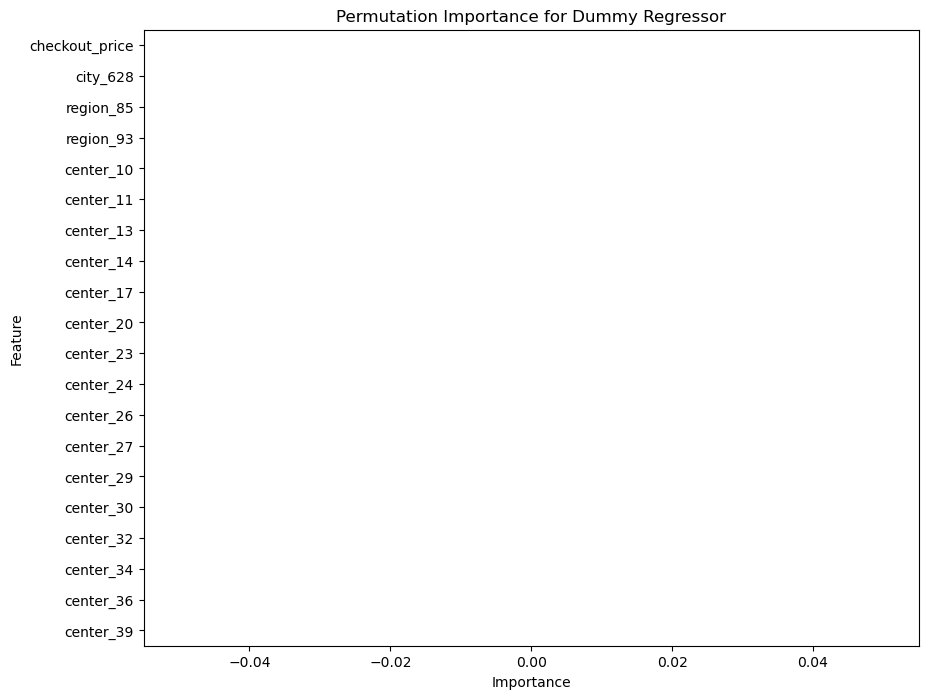

Evaluating Linear Regression...
Time taken for Linear Regression fitting: 0.02 minutes
Negative predictions found for model Linear Regression
Negative train predictions: [-92.890625   -21.27539062 -37.578125   ...  -0.16992188 -18.52587891
  -8.94482422]
Negative validation predictions: [ -17.71728516  -73.32714844  -82.35888672 ... -252.27539062  -59.97119141
 -111.27880859]
Train MSE: 72809.42
Train R2: 0.53
Train RMSLE: 1.7797
Validation MSE: 73178.19
Validation R2: 0.53
Validation RMSLE: 1.7875
Test MSE: 77451.52
Test R2: 0.52
Test RMSLE: 1.7814
                        Feature    Importance
2                       op_area  7.776167e+19
79        meal_category_Seafood  1.692800e+19
84              cuisine_Italian  1.478926e+19
224          center_type_TYPE_C  1.395557e+19
223          center_type_TYPE_B  1.077202e+19
73   meal_category_Other Snacks  7.300847e+18
68      meal_category_Beverages  6.582111e+18
75          meal_category_Pizza  6.016955e+18
72           meal_category_Fis

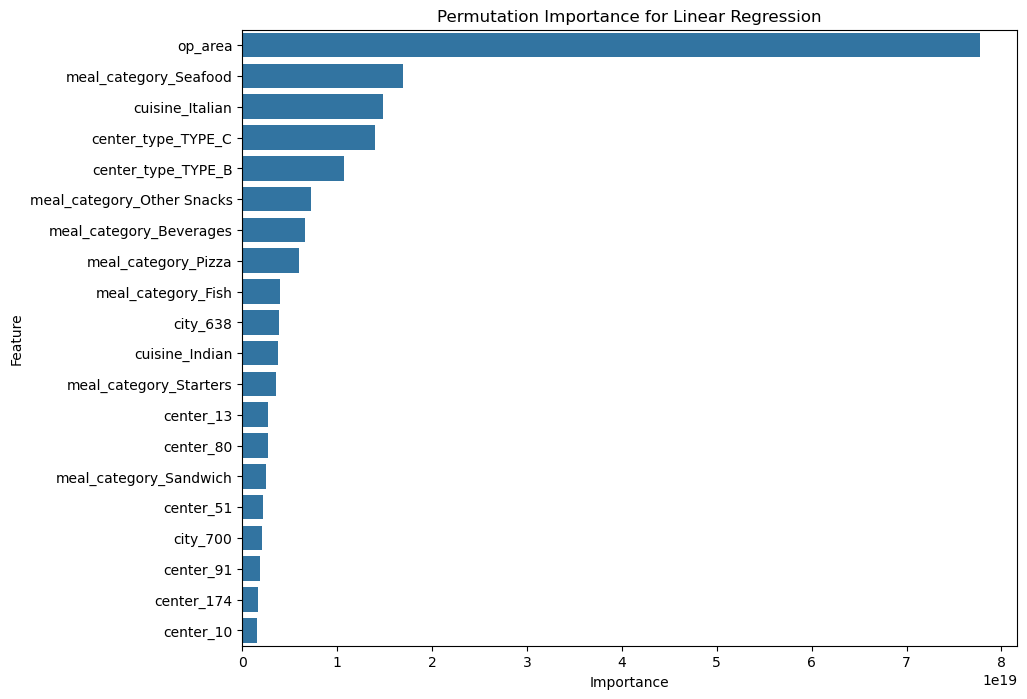

Evaluating Gradient Boosting...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
      Iter       Train Loss   Remaining Time 
         1      154213.9164           12.13m
         2      152734.4972           12.03m
         3      151278.1203           11.89m
         4      149849.5077           11.83m
         5      148450.0354           11.78m
         6      147080.6527           11.68m
         7      145734.7800           11.62m
         8      144414.3779           11.58m
         9      143127.3707           11.52m
        10      141872.6496           11.47m
        11      140516.2028           11.42m
        12      139170.1549           11.36m
        13      137927.4487           11.30m
        14      136641.6457           11.24m
        15      135461.6095           11.18m
        16      134253.7678           11.11m
        17      133099.1741           11.04m
        18      131887.5713           10.99m
        19      130800.0661           10.92m
       

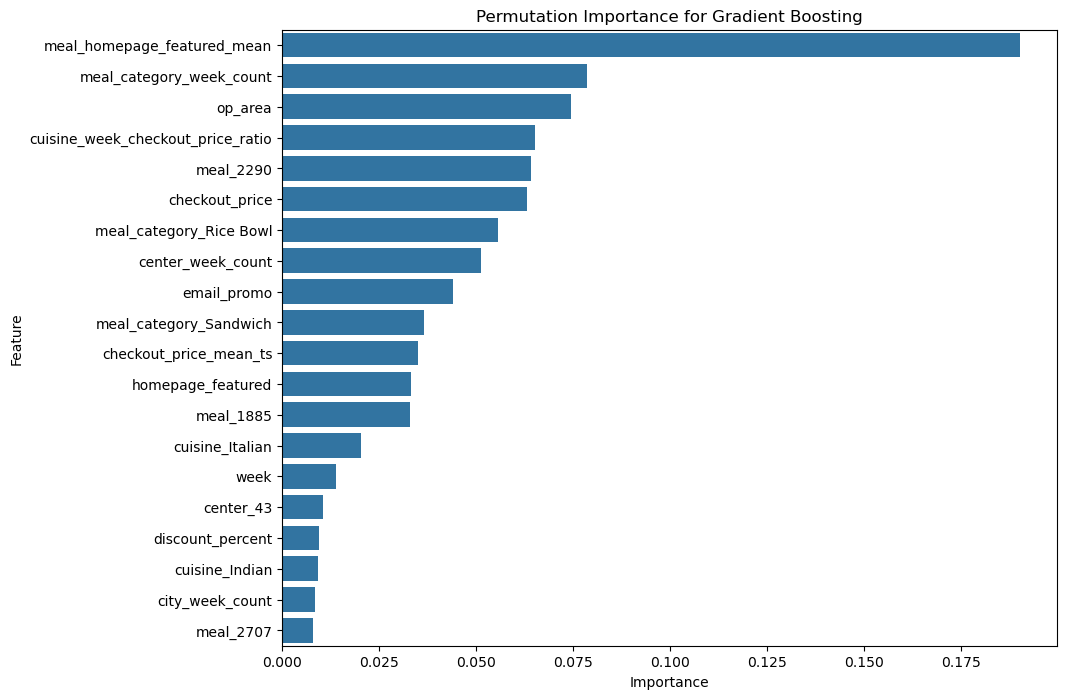

Evaluating CatBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
0:	learn: 392.5865816	total: 148ms	remaining: 29.4s
3:	learn: 386.9997588	total: 177ms	remaining: 8.67s
6:	learn: 381.3667175	total: 206ms	remaining: 5.68s
9:	learn: 376.0180130	total: 235ms	remaining: 4.47s
12:	learn: 370.8234624	total: 264ms	remaining: 3.8s
15:	learn: 365.8563822	total: 293ms	remaining: 3.37s
18:	learn: 361.1594416	total: 321ms	remaining: 3.06s
21:	learn: 356.5340460	total: 350ms	remaining: 2.83s
24:	learn: 352.0364937	total: 379ms	remaining: 2.65s
27:	learn: 347.7682315	total: 407ms	remaining: 2.5s
30:	learn: 343.7047213	total: 436ms	remaining: 2.38s
33:	learn: 339.6614734	total: 465ms	remaining: 2.27s
36:	learn: 335.8114166	total: 493ms	remaining: 2.17s
39:	learn: 331.9271518	total: 523ms	remaining: 2.09s
42:	learn: 328.3157945	total: 551ms	remaining: 2.01s
45:	learn: 324.7824995	total: 581ms	remaining: 1.94s
48:	learn: 321.4115022	total: 609ms	remaining: 1.88s
51:	learn: 317.898461

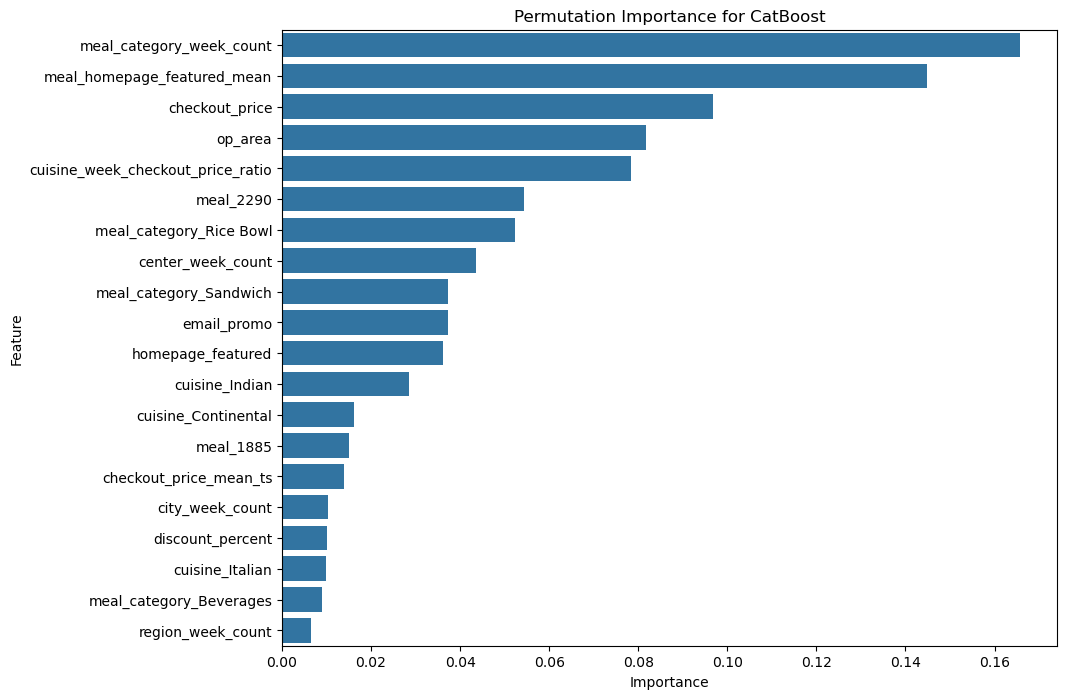

Evaluating XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters: {'model__n_estimators': 200, 'model__max_depth': 5, 'model__learning_rate': 0.01}
Best score: -0.8056353083453693
Best estimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['checkout_price',
                                                   'discount_percent',
                                                   'op_area', 'week',
                                                   'email_promo',
                                                   'homepage_featured',
                                                   'discount_percent_mean_ts',
                                                   'checkout_price_mean_ts',
                                                   'email_promo_mean_ts',
                                                   'homepage_featured_mean_ts',
     

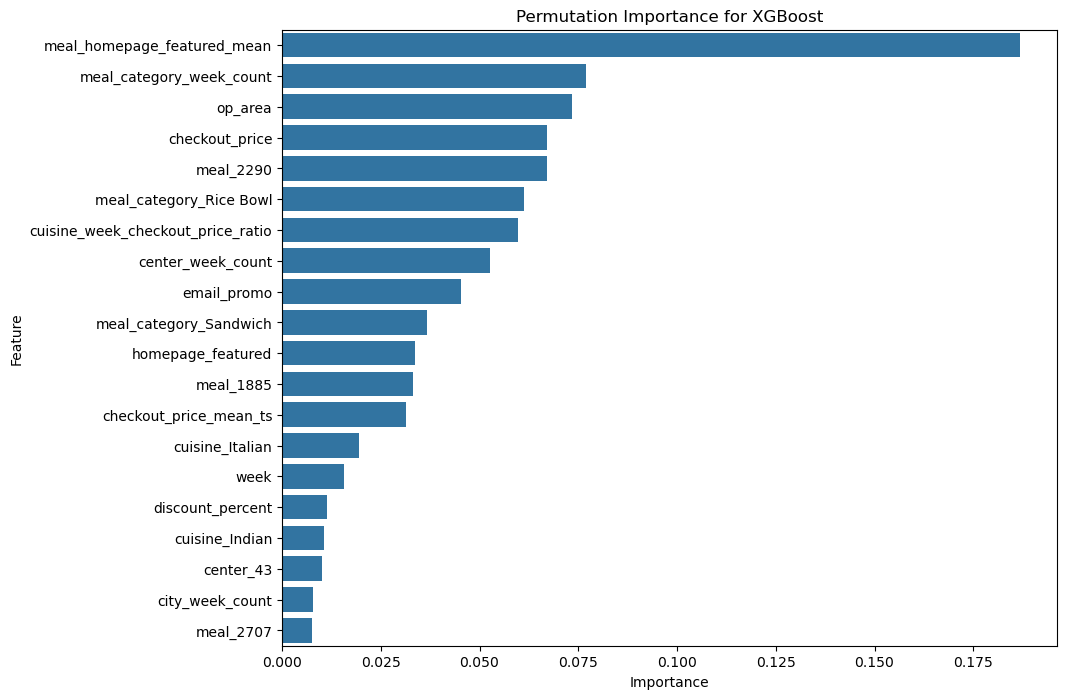

Evaluating Decision Tree...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters: {'model__min_samples_split': 20, 'model__max_depth': 10}
Best score: -0.476238176826143
Best estimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['checkout_price',
                                                   'discount_percent',
                                                   'op_area', 'week',
                                                   'email_promo',
                                                   'homepage_featured',
                                                   'discount_percent_mean_ts',
                                                   'checkout_price_mean_ts',
                                                   'email_promo_mean_ts',
                                                   'homepage_featured_mean_ts',
                         

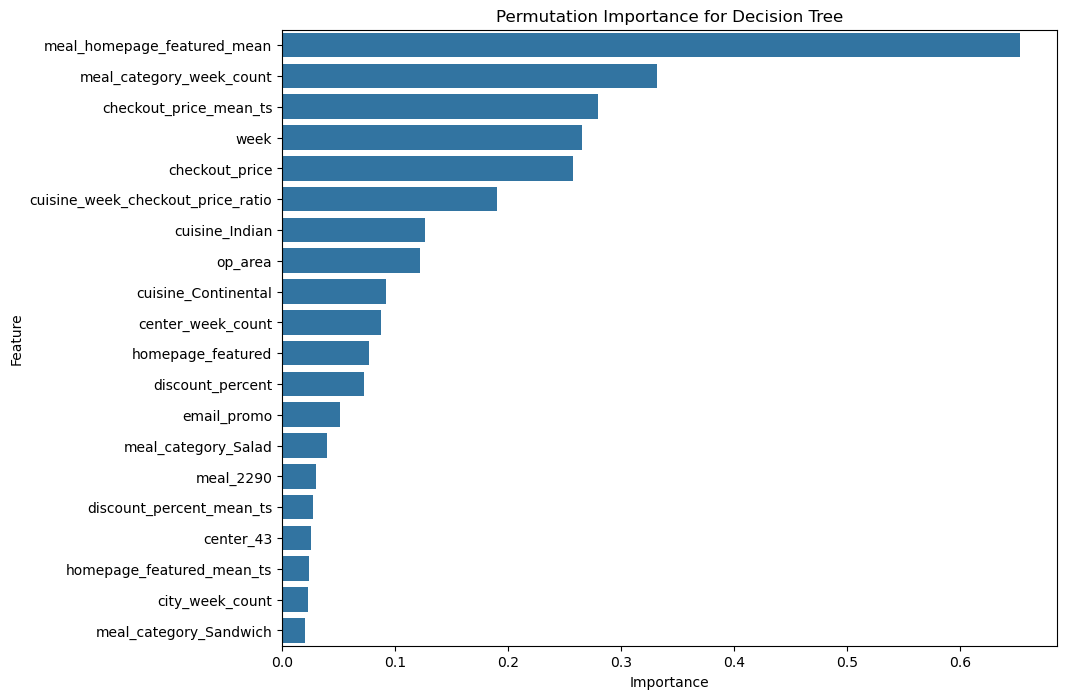

Evaluating Neural Network...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'model__solver': 'adam', 'model__learning_rate': 'adaptive', 'model__hidden_layer_sizes': (50, 50, 50), 'model__alpha': 0.0001, 'model__activation': 'relu'}
Best score: nan
Best estimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['checkout_price',
                                                   'discount_percent',
                                                   'op_area', 'week',
                                                   'email_promo',
                                                   'homepage_featured',
                                                   'discount_percent_mean_ts',
                                                   'checkout_price_mean_ts',
                                                   'email_promo_mean_ts',
                 

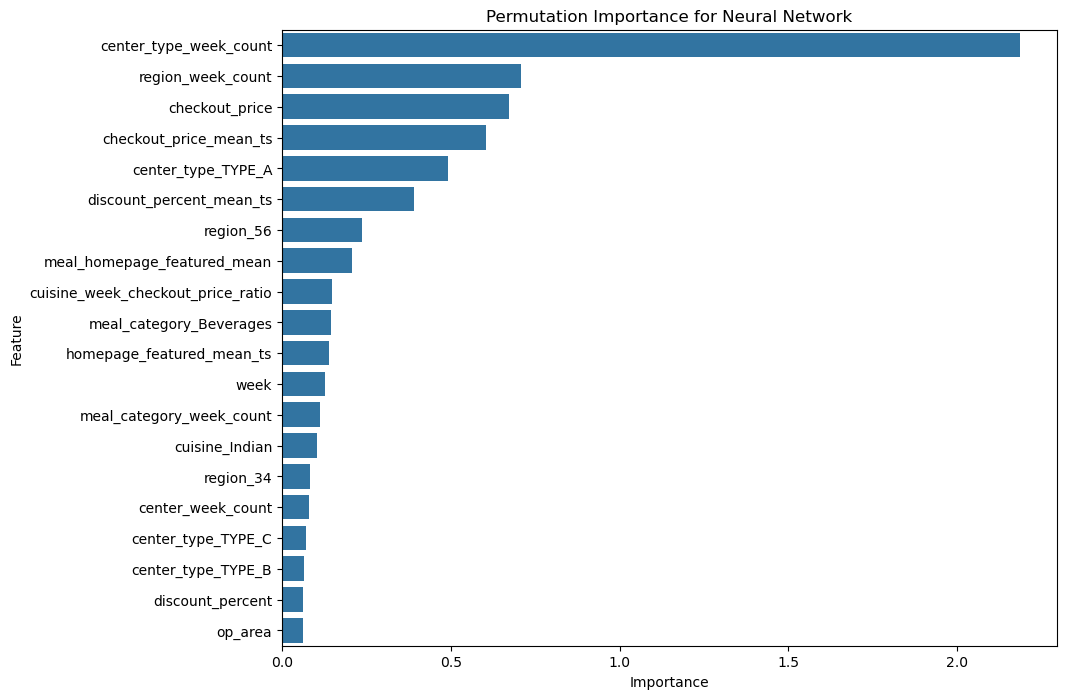

Evaluating Random Forest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__max_depth': 10}
Best score: -0.4552427646547293
Best estimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['checkout_price',
                                                   'discount_percent',
                                                   'op_area', 'week',
                                                   'email_promo',
                                                   'homepage_featured',
                                                   'discount_percent_mean_ts',
                                                   'checkout_price_mean_ts',
                                                   'email_promo_mean_ts',
                                                   'homepage_featured_mean_

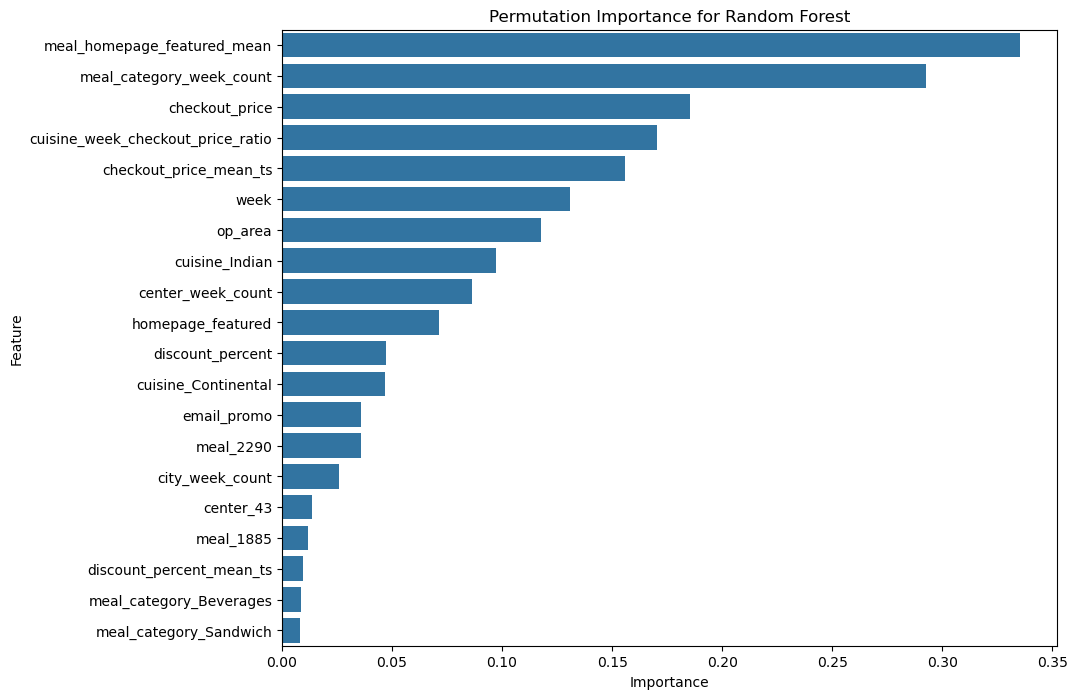

Evaluating Keras Neural Network...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


ValueError: Invalid parameter activation for estimator KerasRegressor.
This issue can likely be resolved by setting this parameter in the KerasRegressor constructor:
`KerasRegressor(activation=relu)`
Check the list of available parameters with `estimator.get_params().keys()`

In [205]:
numerical_features = ['checkout_price', 'discount_percent', 'op_area', 'week', 'email_promo', 'homepage_featured', 'discount_percent_mean_ts', 'checkout_price_mean_ts', 'email_promo_mean_ts', 'homepage_featured_mean_ts', 'center_week_count', 'city_week_count', 'region_week_count', 'center_type_week_count', 'meal_category_week_count', 'meal_homepage_featured_mean', 'cuisine_week_checkout_price_ratio']
categorical_features = ['meal', 'meal_category', 'cuisine', 'city', 'region', 'center', 'center_type']

results_df, feature_importances = evaluate_models(df, 'num_orders', numerical_features, categorical_features)

## Model Keras Neural Network

In [218]:
import time
keras_model_only = {
    "Keras Neural Network": keras_model
}
keras_params_only = {
    "Keras Neural Network": {
        'model__optimizer': ['adam', 'rmsprop'],
        'model__batch_size': [32, 64],
        'model__epochs': [100, 200],
        'model__activation': ['relu', 'tanh'],
        'model__first_layer_nodes': [128, 256],
        'model__second_layer_nodes': [64, 128],
        'model__third_layer_nodes': [32, 64]
    }
}

# Function to evaluate only the Keras Neural Network
def evaluate_keras_model(df, target_col, numerical_features, categorical_features, models, params, results=None, feature_importances=None):
    if results is None:
        results = []
    if feature_importances is None:
        feature_importances = {}

    X = df[numerical_features + categorical_features]
    y = df[target_col]
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")
        grid_search_time, fit_time, best_model = None, None, model

        if model_name in params:
            pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('model', model)])
            start_time = time.time()
            grid_search = RandomizedSearchCV(pipeline, params[model_name], scoring='neg_mean_squared_log_error', cv=3, n_iter=10, n_jobs=-1, verbose=3, random_state=42)
            grid_search.fit(X_train, y_train)
            grid_search_time = (time.time() - start_time) / 60
            print(f"Best parameters: {grid_search.best_params_}")
            print(f"Best score: {grid_search.best_score_}")
            print(f"Best estimator: {grid_search.best_estimator_}")
            print(f"Time taken for {model_name} grid search: {grid_search_time:.2f} minutes")

            best_model = grid_search.best_estimator_

            start_time = time.time()
            best_model.fit(X_train, y_train)
            fit_time = (time.time() - start_time) / 60 
            print(f"Time taken for {model_name} fitting: {fit_time:.2f} minutes")
        else:
            pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('model', model)])
            start_time = time.time()
            pipeline.fit(X_train, y_train)
            fit_time = (time.time() - start_time) / 60 
            print(f"Time taken for {model_name} fitting: {fit_time:.2f} minutes")
            best_model = pipeline

        # Save the trained model
        joblib.dump(best_model, f"{model_name}_best_model.pkl")

        # Predictions for train and validation sets
        train_predictions = best_model.predict(X_train)
        val_predictions = best_model.predict(X_val)
        test_predictions = best_model.predict(X_test)

        # Debug: Check predictions for negative values
        negative_train_predictions = train_predictions[train_predictions < 0]
        negative_val_predictions = val_predictions[val_predictions < 0]
        negative_test_predictions = test_predictions[test_predictions < 0]
        if len(negative_train_predictions) > 0 or len(negative_val_predictions) > 0 or len(negative_test_predictions) > 0:
            print(f"Negative predictions found for model {model_name}")
            if len(negative_train_predictions) > 0:
                print(f"Negative train predictions: {negative_train_predictions}")
            if len(negative_val_predictions) > 0:
                print(f"Negative validation predictions: {negative_val_predictions}")
            # Clip predictions to ensure non-negative values
            train_predictions = np.clip(train_predictions, 0, None)
            val_predictions = np.clip(val_predictions, 0, None)
            test_predictions = np.clip(test_predictions, 0, None)

        
        train_mse = mean_squared_error(y_train, train_predictions)
        train_rmsle = np.sqrt(mean_squared_log_error(y_train, train_predictions))
        train_r2 = r2_score(y_train, train_predictions)
        val_mse = mean_squared_error(y_val, val_predictions)
        val_rmsle = np.sqrt(mean_squared_log_error(y_val, val_predictions))
        val_r2 = r2_score(y_val, val_predictions)
        test_mse = mean_squared_error(y_test, test_predictions)
        test_rmsle = np.sqrt(mean_squared_log_error(y_test, test_predictions))
        test_r2 = r2_score(y_test, test_predictions)
        print(f"Train MSE: {train_mse:.2f}")
        print(f"Train R2: {train_r2:.2f}")
        print(f"Train RMSLE: {train_rmsle:.4f}")
        print(f"Validation MSE: {val_mse:.2f}")
        print(f"Validation R2: {val_r2:.2f}")
        print(f"Validation RMSLE: {val_rmsle:.4f}")
        print(f"Test MSE: {test_mse:.2f}")
        print(f"Test R2: {test_r2:.2f}")
        print(f"Test RMSLE: {test_rmsle:.4f}")

        results.append({
            "Model": model_name,
            "Train MSE": train_mse,
            "Train R2": train_r2,
            "Train RMSLE": train_rmsle,
            "Train RMSLE*100": 100 * train_rmsle,
            "Validation MSE": val_mse,
            "Validation R2": val_r2,
            "Validation RMSLE": val_rmsle,
            "Validation RMSLE*100": 100 * val_rmsle,
            "Test MSE": test_mse,
            "Test R2": test_r2,
            "Test RMSLE": test_rmsle,
            "Test RMSLE*100": 100 * test_rmsle,
            "Grid Search Time (s)": grid_search_time,
            "Fit Time (s)": fit_time,
            "Best Params": best_model.get_params() if model_name in params else "N/A"
        })

        perm_importance = permutation_importance(best_model['model'], preprocessor.transform(X_val), y_val, n_repeats=10, random_state=42)
        importance_df = pd.DataFrame({
            'Feature': list(preprocessor.transformers_[0][2]) + list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)),
            'Importance': perm_importance.importances_mean
        }).sort_values(by='Importance', ascending=False)

        feature_importances[model_name] = importance_df  # Save the feature importances to the dictionary
        
        top_features = importance_df.head(20)
        print(top_features)
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=top_features)
        plt.title(f'Permutation Importance for {model_name}')
        plt.show()
        
    results_df = pd.DataFrame(results)
    print(results_df)
    return results_df, feature_importances

# Call the evaluate function with only the Keras Neural Network
results_df, feature_importances = evaluate_keras_model(df, 'num_orders', numerical_features, categorical_features, keras_model_only, keras_params_only, results, feature_importances)

Evaluating Keras Neural Network...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


                               Feature  Importance
0                       checkout_price    0.292064
16   cuisine_week_checkout_price_ratio    0.171912
15         meal_homepage_featured_mean    0.120059
140                          region_56    0.113096
13              center_type_week_count    0.090811
14            meal_category_week_count    0.065637
24                           meal_1248    0.064619
59                           meal_2631    0.057201
68             meal_category_Beverages    0.056690
3                                 week    0.053616
12                   region_week_count    0.053477
4                          email_promo    0.046675
222                 center_type_TYPE_A    0.038927
74                 meal_category_Pasta    0.037157
1                     discount_percent    0.036117
47                           meal_2290    0.027997
55                           meal_2539    0.027076
167                          center_53    0.027028
2                              

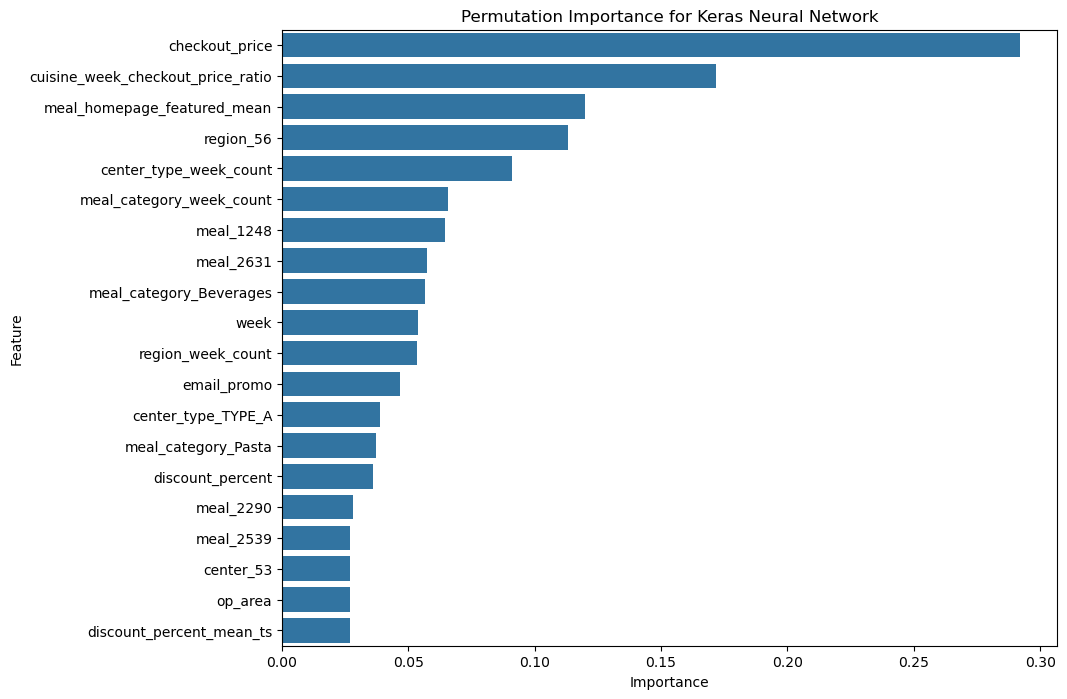

In [227]:
feature_importances = joblib.load('feature_importances.pkl')

# Retrieve the permutation importance for Keras Neural Network since it didn't plot above 
keras_feature_importance = feature_importances.get('Keras Neural Network')

# Check if the importance is retrieved correctly
if keras_feature_importance is not None:
    # Plot the top 20 important features
    top_features = keras_feature_importance.head(20)
    print(top_features)
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title('Permutation Importance for Keras Neural Network')
    plt.show()
else:
    print("No feature importance data found for Keras Neural Network.")

## Model Time Series XGBoost

In [240]:
def evaluate_time_series_model(df, target_col, numerical_features, categorical_features, results, feature_importances):

    # Split the data into training, validation, and test sets based on time series
    df_sorted = df.sort_values(by='week')
    X_ts_train = df_sorted[df_sorted['week'] <= df_sorted['week'].quantile(0.6)]
    X_ts_temp = df_sorted[df_sorted['week'] > df_sorted['week'].quantile(0.6)]
    X_ts_val = X_ts_temp[X_ts_temp['week'] <= df_sorted['week'].quantile(0.8)]
    X_ts_test = X_ts_temp[X_ts_temp['week'] > df_sorted['week'].quantile(0.8)]
    y_ts_train = X_ts_train[target_col]
    y_ts_val = X_ts_val[target_col]
    y_ts_test = X_ts_test[target_col]
    X_ts_train = X_ts_train.drop(columns=[target_col])
    X_ts_val = X_ts_val.drop(columns=[target_col])
    X_ts_test = X_ts_test.drop(columns=[target_col])
    
    # Define preprocessor for numerical and categorical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
        ]
    )

    # Evaluate the time-series model using XGBoost
    ts_model = xgb.XGBRegressor(tree_method='hist', random_state=42, n_jobs=-1)

    param_grid = {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.8, 1.0]
    }

    ts_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', ts_model)])
    grid_search = RandomizedSearchCV(ts_pipeline, param_grid, scoring='neg_mean_squared_log_error', cv=3, n_iter=10, n_jobs=-1, verbose=3, random_state=42)
    start_time = time.time()
    grid_search.fit(X_ts_train, y_ts_train)
    grid_search_time = (time.time() - start_time) / 60
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score: {grid_search.best_score_}")
    print(f"Best estimator: {grid_search.best_estimator_}")
    print(f"Time taken for Time Series XGBoost grid search: {grid_search_time:.2f} minutes")

    best_model = grid_search.best_estimator_

    start_time = time.time()
    best_model.fit(X_ts_train, y_ts_train)
    fit_time = (time.time() - start_time) / 60 
    print(f"Time taken for Time Series XGBoost fitting: {fit_time:.2f} minutes")

    # Predictions for train, validation, and test sets
    train_predictions = best_model.predict(X_ts_train)
    val_predictions = best_model.predict(X_ts_val)
    test_predictions = best_model.predict(X_ts_test)

    # Clip negative predictions to zero
    train_predictions = np.clip(train_predictions, 0, None)
    val_predictions = np.clip(val_predictions, 0, None)
    test_predictions = np.clip(test_predictions, 0, None)

    # Calculate performance metrics
    train_mse = mean_squared_error(y_ts_train, train_predictions)
    train_r2 = r2_score(y_ts_train, train_predictions)
    train_rmsle = np.sqrt(mean_squared_log_error(y_ts_train, train_predictions))
    val_mse = mean_squared_error(y_ts_val, val_predictions)
    val_r2 = r2_score(y_ts_val, val_predictions)
    val_rmsle = np.sqrt(mean_squared_log_error(y_ts_val, val_predictions))
    test_mse = mean_squared_error(y_ts_test, test_predictions)
    test_r2 = r2_score(y_ts_test, test_predictions)
    test_rmsle = np.sqrt(mean_squared_log_error(y_ts_test, test_predictions))
    print(f"Train MSE: {train_mse:.2f}")
    print(f"Train R2: {train_r2:.2f}")
    print(f"Train RMSLE: {train_rmsle:.4f}")
    print(f"Validation MSE: {val_mse:.2f}")
    print(f"Validation R2: {val_r2:.2f}")
    print(f"Validation RMSLE: {val_rmsle:.4f}")
    print(f"Test MSE: {test_mse:.2f}")
    print(f"Test R2: {test_r2:.2f}")
    print(f"Test RMSLE: {test_rmsle:.4f}")

    # Store results
    results.append({
        "Model": "Time Series XGBoost",
        "Train MSE": train_mse,
        "Train R2": train_r2,
        "Train RMSLE": train_rmsle,
        "Train RMSLE*100": 100 * train_rmsle,
        "Validation MSE": val_mse,
        "Validation R2": val_r2,
        "Validation RMSLE": val_rmsle,
        "Validation RMSLE*100": 100 * val_rmsle,
        "Test MSE": test_mse,
        "Test R2": test_r2,
        "Test RMSLE": test_rmsle,
        "Test RMSLE*100": 100 * test_rmsle,
        "Grid Search Time (s)": grid_search_time,
        "Fit Time (s)": fit_time,
        "Best Params": grid_search.best_params_
    })

    # Save the trained model
    joblib.dump(best_model, "Time_Series_XGBoost_best_model.pkl")

    # Compute permutation importance
    # Use the preprocessor from the best_model to transform the data
    X_ts_val_transformed = best_model.named_steps['preprocessor'].transform(X_ts_val)
    perm_importance = permutation_importance(best_model.named_steps['model'], X_ts_val_transformed, y_ts_val, n_repeats=10, random_state=42)
    importance_df = pd.DataFrame({
        'Feature': list(best_model.named_steps['preprocessor'].transformers_[0][2]) + list(best_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)),
        'Importance': perm_importance.importances_mean
    }).sort_values(by='Importance', ascending=False)

    feature_importances["Time Series XGBoost"] = importance_df

    # Plot top 20 important features
    top_features = importance_df.head(20)
    print(top_features)
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title('Permutation Importance for Time Series XGBoost')
    plt.show()

    return results, feature_importances

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'model__subsample': 1.0, 'model__n_estimators': 200, 'model__max_depth': 5, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.6}
Best score: -0.8460404906191047
Best estimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['checkout_price',
                                                   'discount_percent',
                                                   'op_area', 'week',
                                                   'email_promo',
                                                   'homepage_featured',
                                                   'discount_percent_mean_ts',
                                                   'checkout_price_mean_ts',
                                                   'email_promo_mean_ts',
                                                 

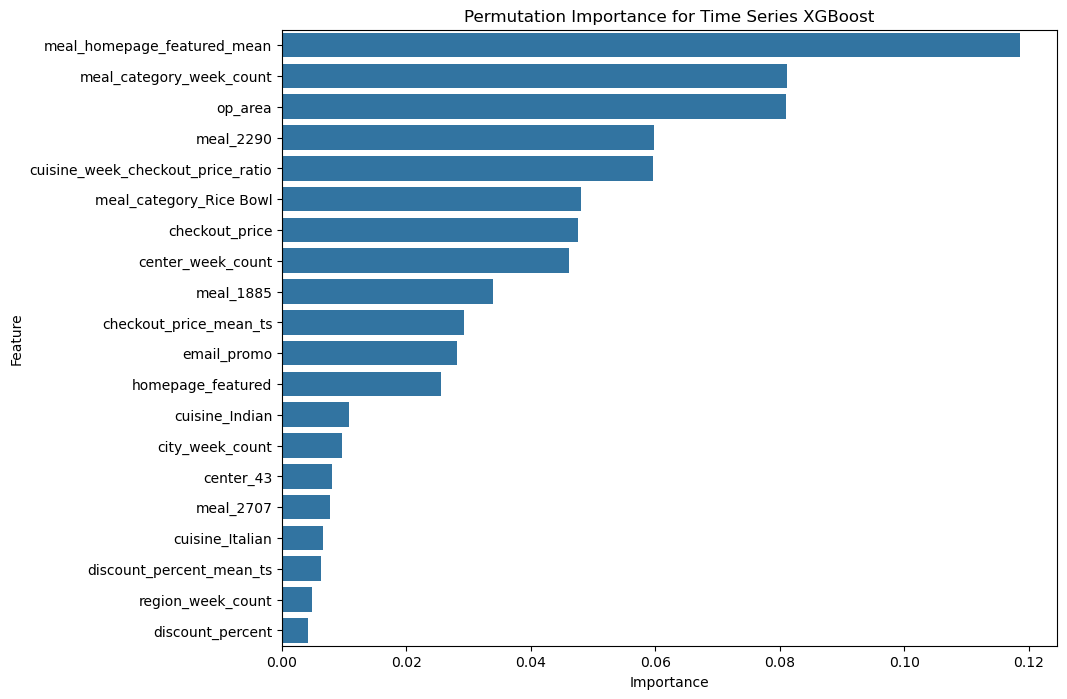

In [241]:
results, feature_importances = evaluate_time_series_model(df, 'num_orders', numerical_features, categorical_features, results, feature_importances)

In [249]:
time_series_results = {
    "Model": "Time Series XGBoost",
    "Train MSE": 55011.39,
    "Train R2": 0.68,
    "Train RMSLE": 0.9023,
    "Train RMSLE*100": 90.23,
    "Validation MSE": 50566.19,
    "Validation R2": 0.63,
    "Validation RMSLE": 0.9155,
    "Validation RMSLE*100": 91.55,
    "Test MSE": 49370.23,
    "Test R2": 0.63,
    "Test RMSLE": 0.9329,
    "Test RMSLE*100": 93.29,
    "Grid Search Time (s)": 0.37,
    "Fit Time (s)": 0.03,
    "Best Params": {
        'model__subsample': 1.0,
        'model__n_estimators': 200,
        'model__max_depth': 5,
        'model__learning_rate': 0.01,
        'model__colsample_bytree': 0.6
    }
}

In [250]:
results.append(time_series_results)

### Save the feature importances and results


In [242]:
joblib.dump(feature_importances, 'feature_importances.pkl')

['feature_importances.pkl']

In [251]:
results_df = pd.DataFrame(results)
results_df.to_csv('results.csv', index=False)

# Results Analysis

In [420]:
results_df.head(10)

,Model,Train MSE,Train R2,Train RMSLE,Train RMSLE*100,Validation MSE,Validation R2,Validation RMSLE,Validation RMSLE*100,Test MSE,Test R2,Test RMSLE,Test RMSLE*100,Grid Search Time (s),Fit Time (s),Best Params
0,Dummy Regressor,155728.660000,0.000000,1.383500,138.350000,155869.450000,-0.000000,1.379700,137.970000,160717.170000,-0.000000,1.387700,138.770000,NaN,0.010000,N/A
1,Linear Regression,72809.420000,0.530000,1.779700,177.970000,73178.190000,0.530000,1.787500,178.750000,77451.520000,0.520000,1.781400,178.140000,NaN,0.020000,N/A
2,Gradient Boosting,50241.110000,0.680000,0.895700,89.570000,52782.700000,0.660000,0.895100,89.510000,55189.160000,0.660000,0.899200,89.920000,27.30000,11.920000,"{'model__n_estimators': 200, 'model__max_depth..."
3,CatBoost,53530.770000,0.660000,0.905600,90.560000,54266.390000,0.650000,0.904600,90.460000,58184.160000,0.640000,0.908300,90.830000,1.16000,0.170000,"{'model__subsample': 1.0, 'model__learning_rat..."
4,XGBoost,51040.600000,0.670000,0.895600,89.560000,53101.580000,0.660000,0.894800,89.480000,56169.060000,0.650000,0.899100,89.910000,0.30000,0.030000,"{'model__n_estimators': 200, 'model__max_depth..."
5,Decision Tree,41483.890000,0.730000,0.681300,68.130000,51215.740000,0.670000,0.688300,68.830000,53068.340000,0.670000,0.688600,68.860000,0.30000,0.100000,"{'model__min_samples_split': 20, 'model__max_d..."
6,Neural Network,12605.890000,0.920000,0.520800,52.080000,21518.550000,0.860000,0.528800,52.880000,23010.390000,0.860000,0.532300,53.230000,66.72000,20.730000,"{'model__solver': 'adam', 'model__learning_rat..."
7,Random Forest,35588.660000,0.770000,0.670900,67.090000,42564.910000,0.730000,0.676700,67.670000,43329.530000,0.730000,0.677000,67.700000,28.40000,12.770000,"{'model__n_estimators': 200, 'model__min_sampl..."
8,Keras Neural Network,18940.528826,0.879979,0.775066,77.506647,20477.848896,0.860785,0.777400,77.739979,22877.871438,0.855177,0.784753,78.475309,85.09184,25.443501,"{'memory': None, 'steps': [('preprocessor', Co..."
10,Time Series XGBoost,55011.387572,0.676107,0.902338,90.233831,50566.192100,0.634139,0.915542,91.554190,49370.225735,0.633677,0.932910,93.291038,0.35244,0.033325,"{'memory': None, 'steps': [('preprocessor', Co..."


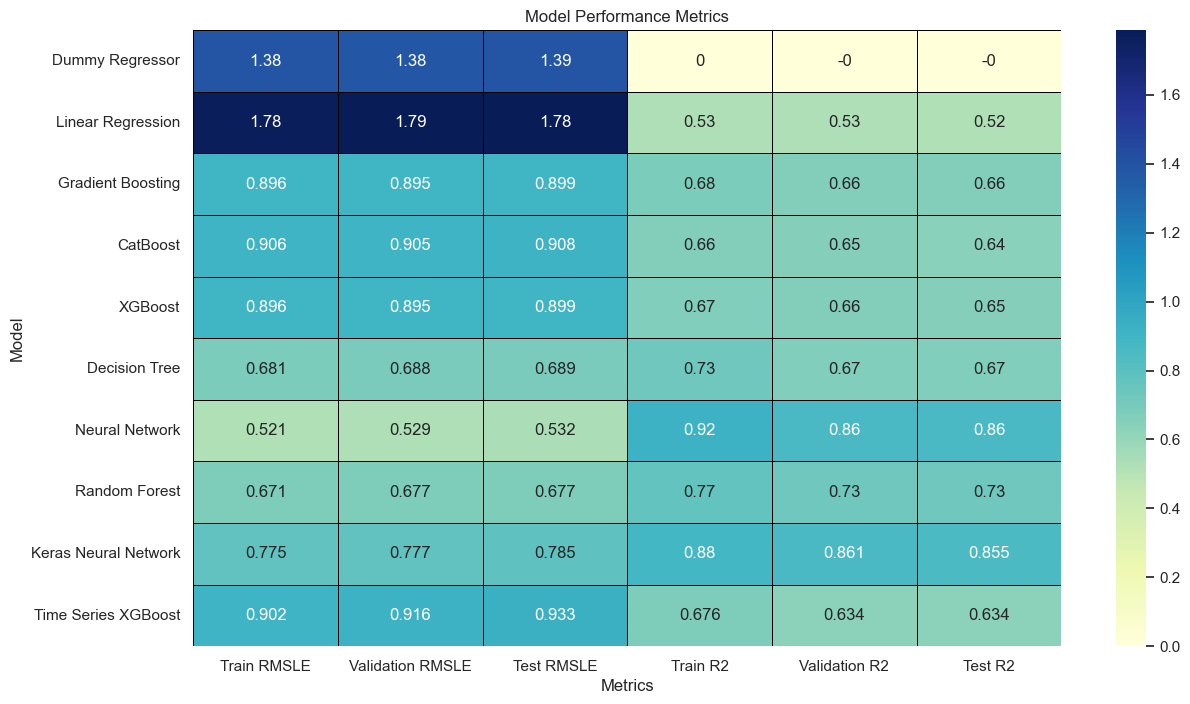

In [514]:
heatmap_data = results_df[['Model', 'Train RMSLE', 'Validation RMSLE', 'Test RMSLE', 'Train R2', 'Validation R2', 'Test R2']]
heatmap_data.set_index('Model', inplace=True)

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.3g', linewidths=0.5, linecolor='black')
plt.title('Model Performance Metrics')
plt.savefig('images/model_performance_metrics.png')
plt.xlabel('Metrics')
plt.ylabel('Model')
plt.show()

* RMSLE (Root Mean Squared Logarithmic Error): Lower values indicate better performance.
* R2 Score: Values closer to 1 indicate better performance.

Based on these criteria the heatmap above shows that the Neural Network model performs the best, with the lowest RMSLE values across the training (0.521), validation (0.529), and test (0.532) sets, and the highest R2 values across all sets (Train: 0.92, Validation: 0.86, Test: 0.86). This indicates that the Neural Network model has the best overall fit and predictive power among the models evaluated.

### Model Comparison (Performance Metric: RMSLE)

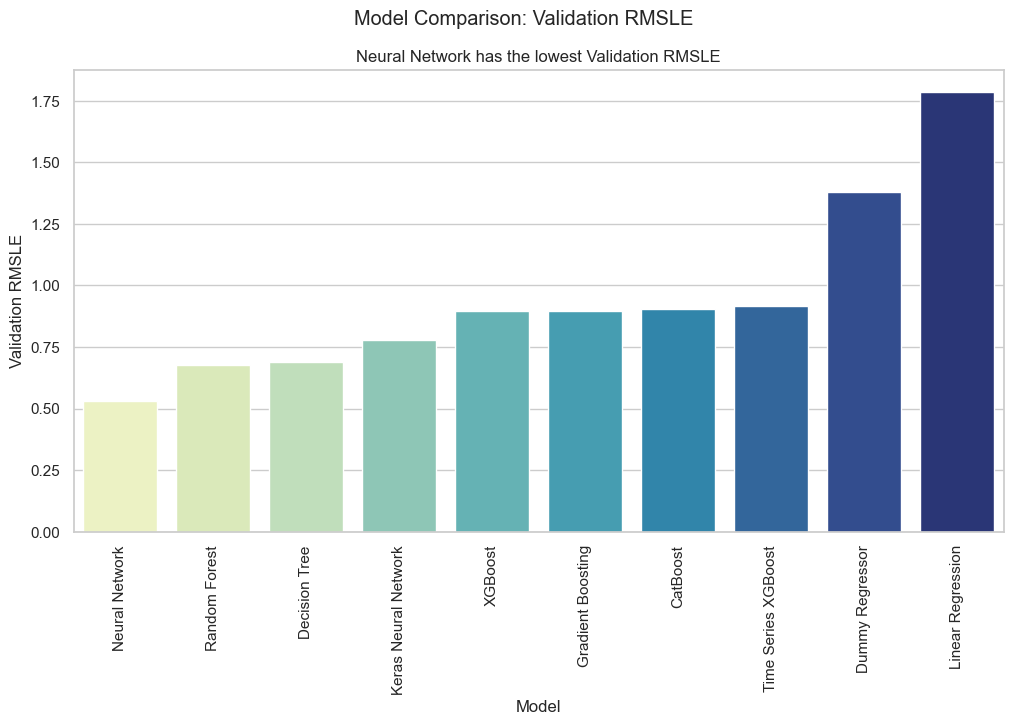

In [513]:
sorted_df = results_df.sort_values(by='Validation RMSLE')
plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Validation RMSLE", data=sorted_df, palette='YlGnBu')
plt.title('Neural Network has the lowest Validation RMSLE')
plt.suptitle('Model Comparison: Validation RMSLE')
plt.ylabel('Validation RMSLE')
plt.xlabel('Model')
plt.xticks(rotation=90)
plt.savefig('images/validation_rmsle.png')
plt.show()

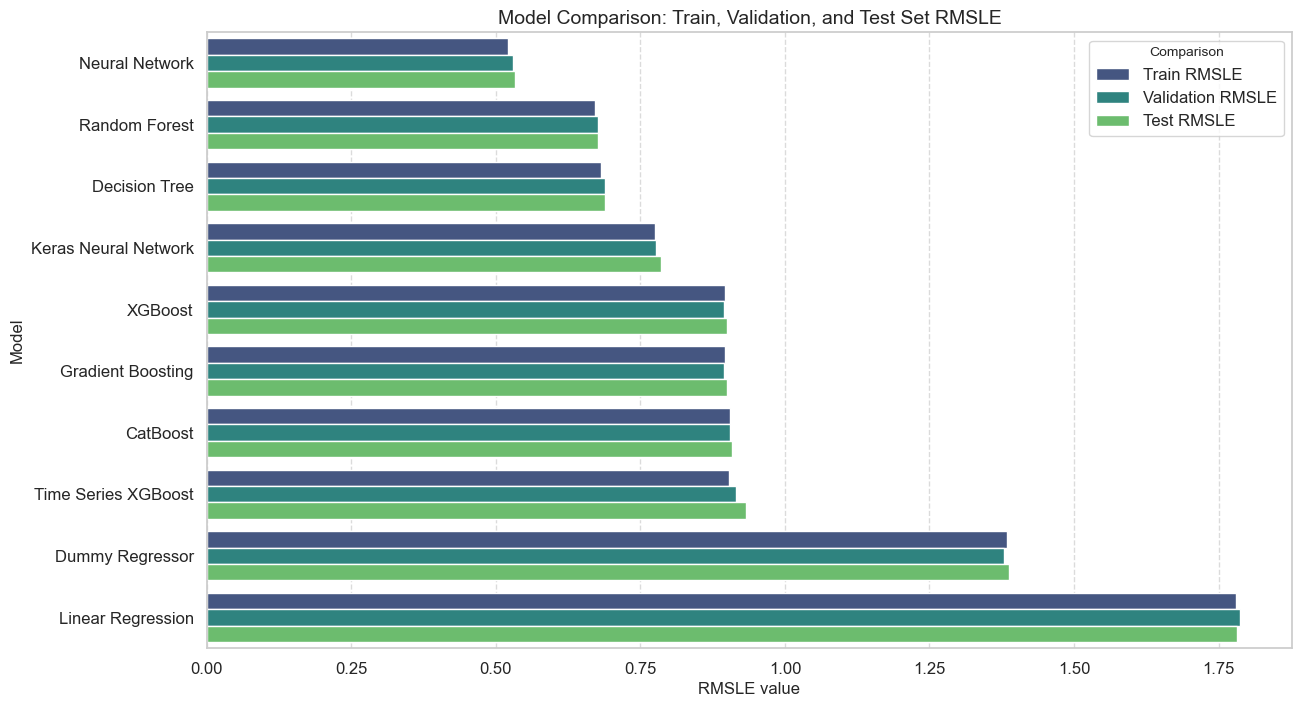

In [539]:
rmsle_df = results_df.melt(id_vars=['Model'], value_vars=['Train RMSLE', 'Validation RMSLE', 'Test RMSLE'],
                                    var_name='Set', value_name='RMSLE')
rmsle_df_sorted = rmsle_df.set_index('Model').loc[sorted_df['Model']].reset_index()
plt.figure(figsize=(14, 8))
sns.barplot(x='RMSLE', y='Model', hue='Set', data=rmsle_df_sorted, palette='viridis', ci=None)
plt.title('Model Comparison: Train, Validation, and Test Set RMSLE', fontsize=14)
plt.xlabel('RMSLE value', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.legend(title='Comparison', fontsize=12, title_fontsize=10, loc='upper right')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig('images/rmsle_comparison.png')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Best Model Analysis

In [542]:
best_model_name = results_df.loc[results_df['Validation RMSLE'].idxmin()]['Model']
print(f"Best Model based on validation RMSLE: {best_model_name}")

Best Model based on validation RMSLE: Neural Network


In [543]:
# Load the best model
best_model = joblib.load(f"{best_model_name}_best_model.pkl")
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['checkout_price',
                                                   'discount_percent',
                                                   'op_area', 'week',
                                                   'email_promo',
                                                   'homepage_featured',
                                                   'discount_percent_mean_ts',
                                                   'checkout_price_mean_ts',
                                                   'email_promo_mean_ts',
                                                   'homepage_featured_mean_ts',
                                                   'center_week_count',
                                                   'city_week_count',
                                                   'region_week_count',
                                                   'center_type_week_count',
                                                   'meal_category_week_count',
                                                   'meal_homepage_featured_mean',
                                                   'cuisine_week_checkout_price_ratio']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['meal', 'meal_category',
                                                   'cuisine', 'city', 'region',
                                                   'center',
                                                   'center_type'])])),
                ('model',
                 MLPRegressor(hidden_layer_sizes=(50, 50, 50),
                              learning_rate='adaptive', max_iter=1000))])

### Shap-Analysis Neural Network

Transformed X_train shape: (273928, 225)
Transformed feature names: ['num__checkout_price' 'num__discount_percent' 'num__op_area' 'num__week'
 'num__email_promo' 'num__homepage_featured'
 'num__discount_percent_mean_ts' 'num__checkout_price_mean_ts'
 'num__email_promo_mean_ts' 'num__homepage_featured_mean_ts'
 'num__center_week_count' 'num__city_week_count' 'num__region_week_count'
 'num__center_type_week_count' 'num__meal_category_week_count'
 'num__meal_homepage_featured_mean'
 'num__cuisine_week_checkout_price_ratio' 'cat__meal_1062'
 'cat__meal_1109' 'cat__meal_1198' 'cat__meal_1207' 'cat__meal_1216'
 'cat__meal_1230' 'cat__meal_1247' 'cat__meal_1248' 'cat__meal_1311'
 'cat__meal_1438' 'cat__meal_1445' 'cat__meal_1525' 'cat__meal_1543'
 'cat__meal_1558' 'cat__meal_1571' 'cat__meal_1727' 'cat__meal_1754'
 'cat__meal_1770' 'cat__meal_1778' 'cat__meal_1803' 'cat__meal_1847'
 'cat__meal_1878' 'cat__meal_1885' 'cat__meal_1902' 'cat__meal_1962'
 'cat__meal_1971' 'cat__meal_1993' 'cat__me

  0%|          | 0/100 [00:00<?, ?it/s]

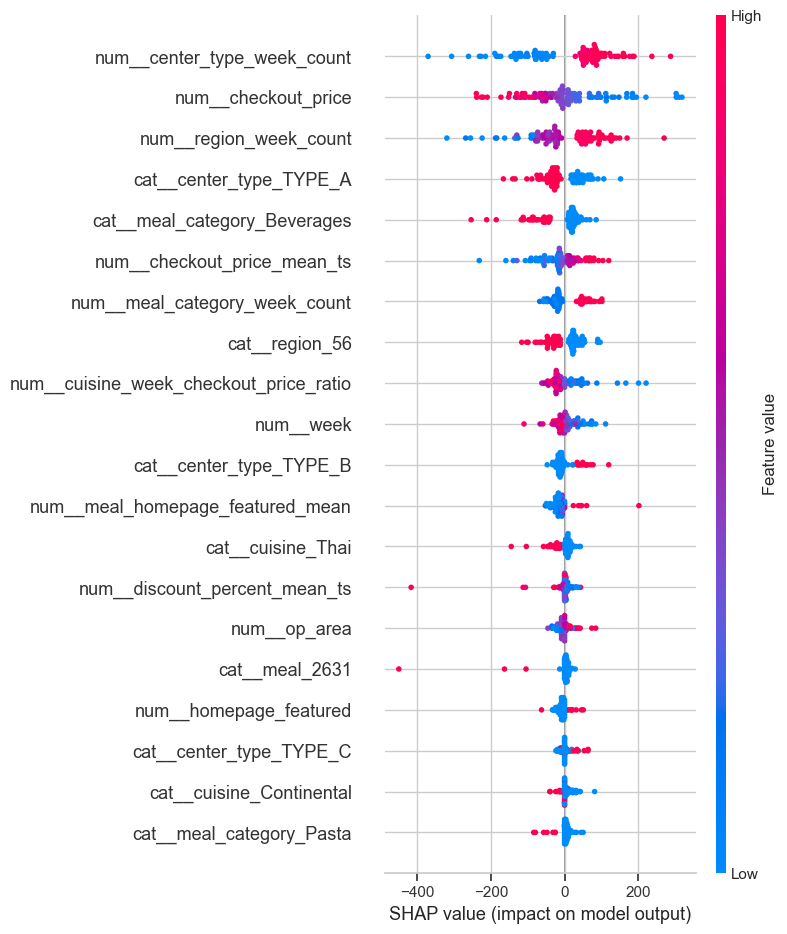

In [548]:
from sklearn.cluster import KMeans

X = df.drop(columns=['num_orders'])
y = df['num_orders']

numerical_features = ['checkout_price', 'discount_percent', 'op_area', 'week', 'email_promo', 'homepage_featured', 'discount_percent_mean_ts', 'checkout_price_mean_ts', 'email_promo_mean_ts', 'homepage_featured_mean_ts', 'center_week_count', 'city_week_count', 'region_week_count', 'center_type_week_count', 'meal_category_week_count', 'meal_homepage_featured_mean', 'cuisine_week_checkout_price_ratio']
categorical_features = ['meal', 'meal_category', 'cuisine', 'city', 'region', 'center', 'center_type']

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Preprocessor for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

# Fit the preprocessor on the training data
preprocessor.fit(X_train)

# Define the full pipeline including preprocessing and the model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', best_model.named_steps['model'])])

# Transform the training data
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
print("Transformed X_train shape:", X_train_transformed.shape)

# Print the feature names after transformation
transformed_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
print("Transformed feature names:", transformed_feature_names)

# Perform k-means clustering on the transformed data
kmeans = KMeans(n_clusters=100, random_state=42).fit(X_train_transformed)  # Adjust the number of clusters as needed
X_train_summary = kmeans.cluster_centers_
print("Transformed X_train_summary shape:", X_train_summary.shape)

# Define a prediction wrapper function that works with the transformed data
def model_predict_transformed(data):
    return pipeline.named_steps['model'].predict(data)

# Create a SHAP explainer using the transformed data
explainer = shap.KernelExplainer(model_predict_transformed, X_train_summary)

# Compute SHAP values for a subset of the data
sample_data = X_train.sample(100, random_state=42)
sample_data_transformed = pipeline.named_steps['preprocessor'].transform(sample_data)
shap_values = explainer.shap_values(sample_data_transformed)

# Create a DataFrame for transformed features
X_transformed = pd.DataFrame(pipeline.named_steps['preprocessor'].transform(X), columns=transformed_feature_names)

# Generate SHAP summary plot
shap.summary_plot(shap_values, X_transformed.loc[sample_data.index])

This plot provides a detailed view of how each feature impacts the model's predictions across different samples.  
<font color="darkred"> Red represents high feature values</font>, <font color="blue">blue represents low feature values</font>.

- **num__center_type_week_count**: High values generally increase the prediction.
- **num__checkout_price**: High values generally decrease the prediction.
- **cat__meal_category_Beverages**: High values generally decrease the prediction.

These features have the largest spread and therefore indicate a high impact on the prediction.

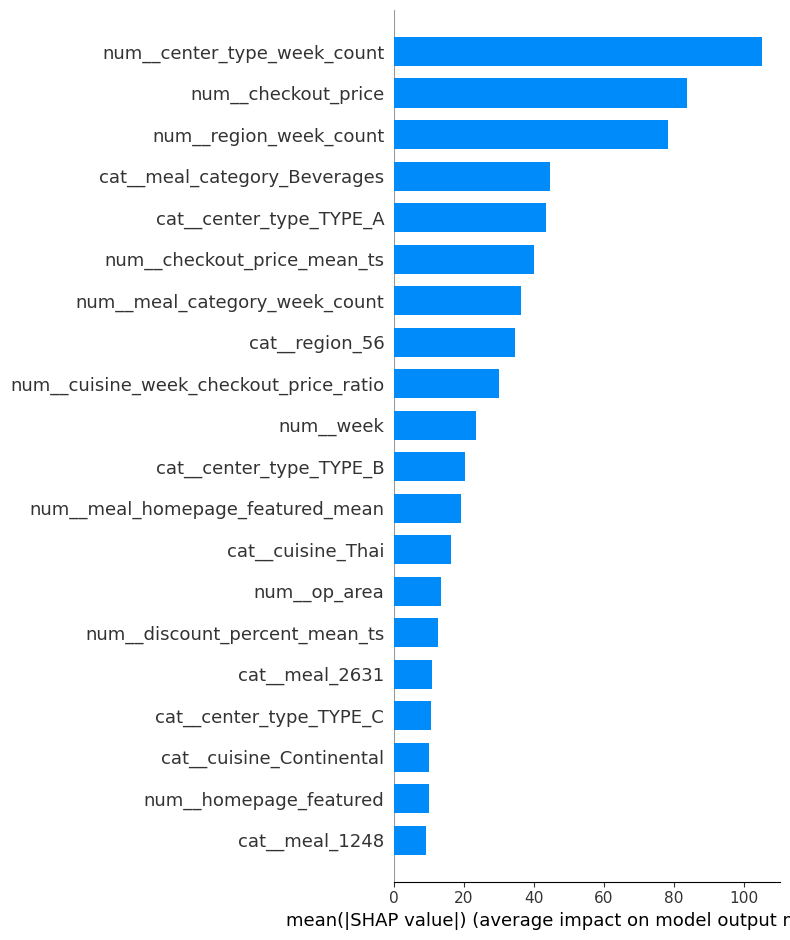

In [467]:
# Generate SHAP summary bar plot
shap.summary_plot(shap_values, X_transformed.loc[sample_data.index], plot_type="bar")

The features `center_type_week_count`, `checkout_price`, and `region_week_count` have the biggest influence on our model's predictions, as also shown on our Permutation Importance plot.

### Actual vs Predicted Number of Orders

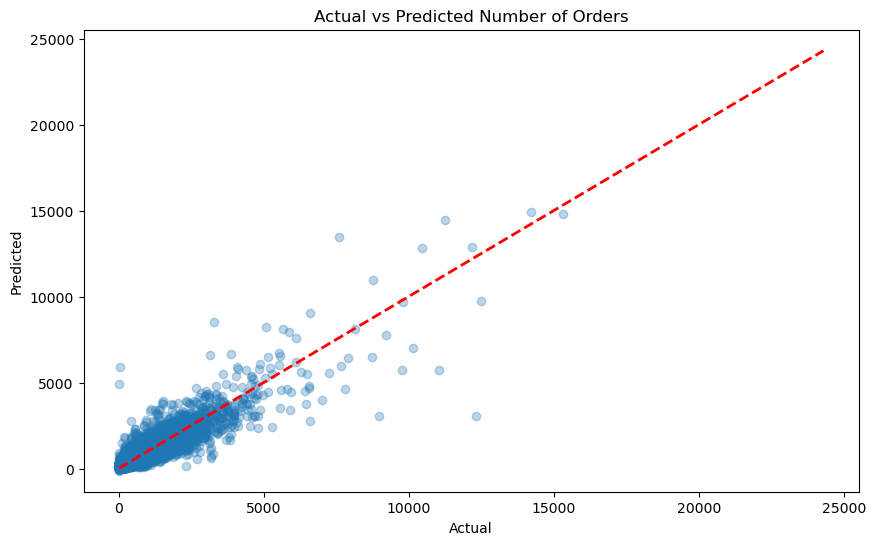

In [459]:
# Plot the predicted values vs the actual values
y_pred = pipeline.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Number of Orders')
plt.show()

* Points close to the diagonal line indicate predictions that are very close to the actual values.
* Points above the diagonal line indicate over-predictions (the predicted value is higher than the actual value).
* Points below the diagonal line indicate under-predictions (the predicted value is lower than the actual value).

### Residuals plot

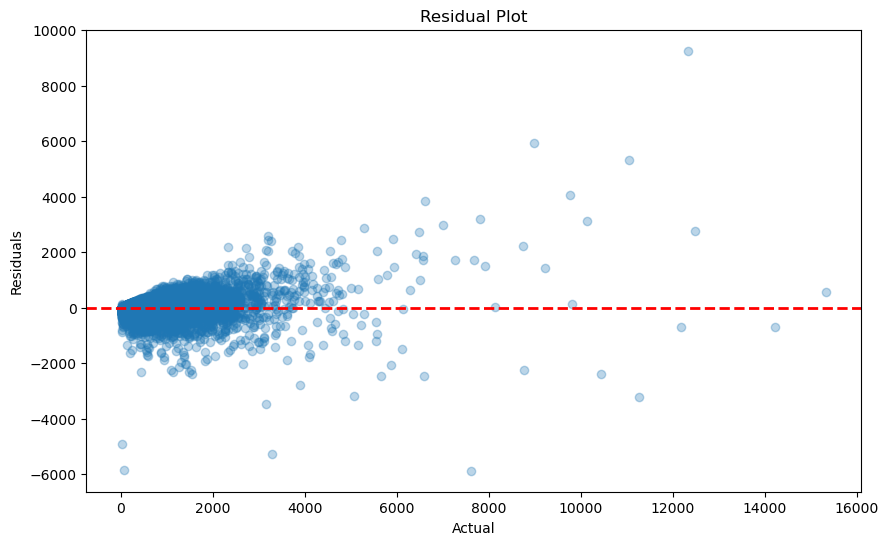

In [416]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

* The residuals are mostly centered around the horizontal line at 0, which indicates that on average, the model's predictions are unbiased.
* The spread of residuals increases with the actual number of orders. This is indicative of heteroscedasticity, where the variance of the errors is not constant across all levels of the actual values. This suggests that the model's prediction accuracy decreases as the number of orders increases.
* The increasing spread of residuals with actual values suggests heteroscedasticity. This can often be addressed by transforming the dependent variable (e.g., using a log transformation) or by using a different modeling approach that can handle varying levels of variance better.

### Actionable Insights

In [457]:
def actionable_insights(feature_importances):
    for model_name, importance_df in feature_importances.items():
        top_features = importance_df.head(10)
        if model_name == 'Neural Network':
            print(f"Top features for {model_name} based on importance:")
            print(top_features)
            print("Recommendations based on feature importance:")
            for feature in top_features['Feature']:
                print(f" - Monitor and optimize {feature} as it significantly impacts demand predictions.")
            print("\n")
            
actionable_insights(feature_importances)

Top features for Neural Network based on importance:
                             Feature  Importance
0             center_type_week_count    2.186659
1                  region_week_count    0.708320
2                     checkout_price    0.671979
3             checkout_price_mean_ts    0.604621
4                 center_type_TYPE_A    0.491849
5           discount_percent_mean_ts    0.391936
6                          region_56    0.236810
7        meal_homepage_featured_mean    0.208374
8  cuisine_week_checkout_price_ratio    0.146612
9            meal_category_Beverages    0.144515
Recommendations based on feature importance:
 - Monitor and optimize center_type_week_count as it significantly impacts demand predictions.
 - Monitor and optimize region_week_count as it significantly impacts demand predictions.
 - Monitor and optimize checkout_price as it significantly impacts demand predictions.
 - Monitor and optimize checkout_price_mean_ts as it significantly impacts demand predictio

# Summary of Findings and Business Value

Our objective was to predict food demand for distribution centers based on past data, identifying key drivers of demand and providing actionable insights for business optimization.
Our predictive model identified three critical features that most significantly influence food demand: `center_type_week_count`, `checkout_price`, and `region_week_count`. The importance of these features was confirmed through both SHAP and permutation importance analyses.

1. **Center Type Week Count**:
  - This feature tracks the number of orders processed by different types of distribution centers (e.g., TYPE_A, TYPE_B, TYPE_C) within a given week.
  - Business Impact: Understanding the operational activity levels across different center types helps in recognizing patterns of peak demand and operational efficiency. For instance, if TYPE_A centers consistently handle higher volumes, this may indicate better logistical capabilities or higher regional demand.

- Actionable Strategies:
  - Operational Scaling: Enhance capacity and resources for center types with higher demand during peak weeks to ensure smooth operations and avoid bottlenecks.
  - Resource Allocation: Optimize workforce and inventory distribution based on the expected activity levels of different center types.

2. **Checkout Price**:
  - This feature represents the selling price of food items.
  - Business Impact: Pricing is a critical lever that directly influences consumer purchasing behavior. The model’s recognition of checkout price as a top feature underscores its importance in driving demand.

- Actionable Strategies:
  - Dynamic Pricing: Implement dynamic pricing strategies to balance demand. For example, offering discounts during low-demand periods can boost sales and help maintain a steady flow of orders.
  - Promotional Campaigns: Use pricing data to design targeted promotional campaigns that attract more customers and increase order volumes during off-peak periods.

3. **Region Week Count**:
  - This feature captures the total number of orders within each region for each week.
  - Business Impact: Regional demand patterns provide insights into geographical variations in consumer behavior and external factors affecting demand.

- Actionable Strategies:
  - Tailored Marketing: Develop region-specific marketing strategies based on demand patterns. For instance, regions with higher demand in certain weeks could benefit from localized promotions and advertisements.
  - Inventory Management: Adjust inventory levels to match regional demand, ensuring that high-demand regions are well-stocked while avoiding overstocking in lower-demand areas.


The insights gained from our predictive model highlight critical factors that influence food demand across distribution centers. By focusing on `center_type_week_count`, `checkout_price`, and `region_week_count`, businesses can implement targeted strategies to optimize operations, pricing, and marketing efforts. These data-driven decisions will enhance operational efficiency, meet consumer demand more effectively, and drive overall business growth.